# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


# Libraries

In [ ]:
import os
import sys
import pickle

import time
import math
import copy

import wget

import numpy as np
import pandas as pd

from scipy.stats import binned_statistic_2d
from scipy import stats

from astropy.io import fits
from astropy.wcs import WCS
from astropy    import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
import astropy.constants as const

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

import torch

from pathlib import Path

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# Paths

In [ ]:
gaia_path = Path('/content/gdrive/MyDrive/Colab Notebooks/gaia/')
ml_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML')
gaskap_path = Path('/content/gdrive/MyDrive/Colab Notebooks/GASKAP')

ml_data_path = ml_path / 'data'
data_path = gaia_path / 'data'
dust_data_path = data_path / 'edenhofer'
gaskap_data_path = gaskap_path / 'data'

local_bubble_data_path = data_path / 'oneill'

gaskap_hires_data_path = gaskap_data_path / 'hires'
gaskap_hires_result_path = gaskap_hires_data_path / 'results'

GASS_data_path = gaskap_data_path / 'GASS'

dynamics_file = data_path / 'galah_dr4_vac_dynamics_240705.fits'
allstar_file = data_path / 'galah_dr4_allstar_240705.fits'
gaia_catalog_file = data_path / 'stellar_params_catalog-1kpc.fits'
gaia_catalog_file = data_path / 'stars_MC_fg.fits'

# Fcn

In [ ]:
#  see GALAH DR4 https://arxiv.org/pdf/2409.19858 Section 7.2.2
vlsr_sun = 15.17 # km/s,


# Create velocity range around the central velocity
velocity_range = np.linspace(-100., 100., 500)

# Define the Gaussian function
def gaussian(x, amp, center, std):
    return amp * np.exp(-(x - center)**2 / (2 * std**2))

In [ ]:
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def download_galah_data(save_path, sobject_id):
    sobject_id = str(sobject_id)
    output_star_id_file = save_path / f'{sobject_id}_allstar_fit_spectrum.fits'
    # print(output_star_id_file)
    save_path = str(save_path)

    if not os.path.exists(output_star_id_file):
        url = f'https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/{sobject_id[:6]}/{sobject_id}/{sobject_id}_allstar_fit_spectrum.fits'
        wget.download(url, out=save_path)

        url = f'https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/{sobject_id[:6]}/{sobject_id}/{sobject_id}_allstar_fit_comparison.pdf'
        wget.download(url, out=save_path)

In [ ]:
def wavelength_to_rv(wavelength_obs, wavelength_rest):
    """
    Calculate radial velocity from observed and rest wavelengths using the
    relativistic Doppler formula.

    Parameters:
    -----------
    wavelength_obs : float or array-like
        Observed wavelength(s) in Angstroms
    wavelength_rest : float
        Rest wavelength in Angstroms

    Returns:
    --------
    float or array-like
        Radial velocity in km/s (positive values indicate redshift/receding motion)
    """
    # Convert wavelengths to float if they're strings
    wavelength_obs = np.float64(wavelength_obs)
    wavelength_rest = np.float64(wavelength_rest)

    # Calculate velocity using relativistic formula
    c = const.c.to('km/s').value  # speed of light in km/s

    # (λ_obs / λ_rest)^2 = (1 + v/c)/(1 - v/c)
    # Solving for v:
    z = wavelength_obs / wavelength_rest
    rv = c * (z**2 - 1) / (z**2 + 1)

    return rv

def wavelength_to_rv_simple(wavelength_obs, wavelength_rest):
    """
    Calculate radial velocity using the simple (non-relativistic) Doppler formula.
    Use this only for v << c.

    Parameters:
    -----------
    wavelength_obs : float or array-like
        Observed wavelength(s) in Angstroms
    wavelength_rest : float
        Rest wavelength in Angstroms

    Returns:
    --------
    float or array-like
        Radial velocity in km/s (positive values indicate redshift/receding motion)
    """
    c = const.c.to('km/s').value  # speed of light in km/s

    # Simple Doppler formula: v/c = Δλ/λ
    # rv = c * (wavelength_obs - wavelength_rest) / wavelength_rest
    rv = c * (wavelength_obs - wavelength_rest) / wavelength_obs

    return rv

In [ ]:
def wavelength_to_vlsrk(observed_wavelengths, rest_wavelength, galactic_l, galactic_b, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25):
    """
    Converts observed wavelengths to VLSRK (velocity relative to the LSR) using the radio convention.

    Args:
        observed_wavelengths (array-like): Array of observed wavelengths (in Angstroms or nanometers).
        rest_wavelength (float): Rest wavelength of the spectral line (in the same units as observed_wavelengths).
        galactic_l (float): Galactic longitude (in degrees).
        galactic_b (float): Galactic latitude (in degrees).
        u_lsr (float, optional): LSR velocity component towards the Galactic Center (km/s).
        v_lsr (float, optional): LSR velocity component in the direction of Galactic rotation (km/s).
        w_lsr (float, optional): LSR velocity component perpendicular to the Galactic plane (km/s).

    Returns:
        numpy.ndarray: Array of VLSRK velocities (in km/s).
    """

    c = const.c.to('km/s').value  # Speed of light in km/s

    observed_wavelengths = np.array(observed_wavelengths)

    # 1. Radial Velocity (Vrad) using radio convention
    vrad = c * (1 - rest_wavelength / observed_wavelengths)

    # 2. Heliocentric Velocity (Vhelio)
    # This requires more information about the observation time and location,
    # and the earth's velocity. For simplicity, we are skipping this part.
    # In practice, you would use astropy.coordinates.EarthLocation and astropy.time.Time,
    # to accurately get the earth's velocity.
    # For now, we are assuming Vhelio = Vrad. Therefore, the result will be slightly off.
    vhelio = vrad

    # 3. VLSRK
    l_rad = np.radians(galactic_l)
    b_rad = np.radians(galactic_b)

    vlsrk = vhelio + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)

    return vlsrk


# vlsrk_velocities = wavelength_to_vlsrk(observed_wavelengths_angstroms, rest_wavelength_angstroms, galactic_l, galactic_b)

In [ ]:
def wavelength_to_vlsrk_with_galah_correction(observed_wavelengths, rest_wavelength, galactic_l, galactic_b, rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25):
    """
    Converts observed wavelengths to VLSRK (velocity relative to the LSR) using the radio convention.

    Args:
        observed_wavelengths (array-like): Array of observed wavelengths (in Angstroms or nanometers).
        rest_wavelength (float): Rest wavelength of the spectral line (in the same units as observed_wavelengths).
        galactic_l (float): Galactic longitude (in degrees).
        galactic_b (float): Galactic latitude (in degrees).
        galah_allstar['rv_comp_1']: See GALAH
        u_lsr (float, optional): LSR velocity component towards the Galactic Center (km/s).
        v_lsr (float, optional): LSR velocity component in the direction of Galactic rotation (km/s).
        w_lsr (float, optional): LSR velocity component perpendicular to the Galactic plane (km/s).

    Returns:
        numpy.ndarray: Array of VLSRK velocities (in km/s).
    """

    c = const.c.to('km/s').value  # Speed of light in km/s

    observed_wavelengths = np.array(observed_wavelengths)

    # 1. Radial Velocity (Vrad) using radio convention
    vrad = c * (1. - rest_wavelength / observed_wavelengths) + rv_comp_1
    # vrad = c * (1. - rest_wavelength/observed_wavelengths)

    # 2. Heliocentric Velocity (Vhelio)
    # This requires more information about the observation time and location,
    # and the earth's velocity. For simplicity, we are skipping this part.
    # In practice, you would use astropy.coordinates.EarthLocation and astropy.time.Time,
    # to accurately get the earth's velocity.
    # For now, we are assuming Vhelio = Vrad. Therefore, the result will be slightly off.
    # vhelio = vrad

    # 3. VLSRK
    l_rad = np.radians(galactic_l)
    b_rad = np.radians(galactic_b)

    # vlsrk = vhelio + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)
    vlsrk = vrad + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)

    return vlsrk


# vlsrk_velocities = wavelength_to_vlsrk(observed_wavelengths_angstroms, rest_wavelength_angstroms, galactic_l, galactic_b)

In [ ]:
# Define the Gaussian function with FWHM
def gaussian(x, A, x0, FWHM):
    sigma = FWHM / 2.3548
    return A * np.exp(-(x-x0)**2 / (2*sigma**2))

In [ ]:
def normalize_spectrum(spectrum):
    min_val = np.min(spectrum)
    max_val = np.max(spectrum)

    # Handle the case where all values are the same
    if max_val == min_val:
        return np.zeros_like(spectrum)  # Return a spectrum of zeros or any consistent value

    # Apply min-max normalization
    normalized_spectrum = (spectrum - min_val) / (max_val - min_val)
    return normalized_spectrum

In [ ]:
def compute_column_density_KI(W_lambda_angstrom):
    """
    Compute the column density for weak lines:

    \[
    W_{\lambda} = \frac{\pi e^2}{m_e c^2} f \lambda^2 N
    \]

    Where:

    - \( e \) is the electron charge
    - \( m_e \) is the electron mass
    - \( c \) is the speed of light
    - \( f \) is the oscillator strength of the transition
    - \( \lambda \) is the wavelength of the line

    """
    # f = 0.3393  # Oscillator strength
    f = 0.332 # Oscillator strength
    lambda_ = 7698.9643 * u.Angstrom  # Wavelength in Angstrom lambda_rest = 7698.9643 # Angstroms

    # Convert equivalent width from Angstrom to meters
    W_lambda_m = (W_lambda_angstrom * u.Angstrom).to(u.m)

    # Compute column density using the formula
    N = (W_lambda_m * const.m_e * const.c**2) / (np.pi * const.e.gauss**2 * f * lambda_.to(u.m)**2)

    return N.to(10**(10)/u.cm**2)  # This ensures the column density is returned in SI units (m^-2)

In [ ]:
def get_angular_distance(glon_src, glat_src, star_glon, star_glat):
    """
    Find stars within a specified angular radius of a source position in Galactic coordinates.

    Parameters:
    -----------
    glon_src : float
        Galactic longitude of the source in degrees
    glat_src : float
        Galactic latitude of the source in degrees
    stars_glon : array-like
        Galactic longitudes of stars in degrees
    stars_glat : array-like
        Galactic latitudes of stars in degrees
    star_ids : array-like
        Identifiers for each star

    Returns:
    --------
    nearby_ids : numpy array
        IDs of stars within the search radius
    nearby_coords : dict
        Dictionary containing coordinates and distances of nearby stars:
        - 'glon': Galactic longitudes
        - 'glat': Galactic latitudes
        - 'distances': Angular distances in degrees
    """

    # Convert everything to radians for spherical trig calculations
    glon_src_rad = np.radians(glon_src)
    glat_src_rad = np.radians(glat_src)
    star_glon_rad = np.radians(star_glon)
    star_glat_rad = np.radians(star_glat)

    # Use the spherical law of cosines to find angular distances
    # cos(c) = sin(lat1)sin(lat2) + cos(lat1)cos(lat2)cos(lon1-lon2)
    angular_distance_rad = np.arccos(
        np.sin(glat_src_rad) * np.sin(star_glat_rad) +
        np.cos(glat_src_rad) * np.cos(star_glat_rad) *
        np.cos(glon_src_rad - star_glon_rad)
    )

    # Convert distances back to degrees
    angular_distance = np.degrees(angular_distance_rad)

    return angular_distance

In [ ]:
def find_nearby_stars(glon_src, glat_src, stars_glon, stars_glat, star_ids, radius_deg):
    """
    Find stars within a specified angular radius of a source position in Galactic coordinates.

    Parameters:
    -----------
    glon_src : float
        Galactic longitude of the source in degrees
    glat_src : float
        Galactic latitude of the source in degrees
    stars_glon : array-like
        Galactic longitudes of stars in degrees
    stars_glat : array-like
        Galactic latitudes of stars in degrees
    star_ids : array-like
        Identifiers for each star
    radius_deg : float
        Search radius in degrees

    Returns:
    --------
    nearby_ids : numpy array
        IDs of stars within the search radius
    nearby_coords : dict
        Dictionary containing coordinates and distances of nearby stars:
        - 'glon': Galactic longitudes
        - 'glat': Galactic latitudes
        - 'distances': Angular distances in degrees
    """

    # Convert everything to radians for spherical trig calculations
    glon_src_rad = np.radians(glon_src)
    glat_src_rad = np.radians(glat_src)
    stars_glon_rad = np.radians(stars_glon)
    stars_glat_rad = np.radians(stars_glat)
    radius_rad = np.radians(radius_deg)

    # Use the spherical law of cosines to find angular distances
    # cos(c) = sin(lat1)sin(lat2) + cos(lat1)cos(lat2)cos(lon1-lon2)
    angular_distances_rad = np.arccos(
        np.sin(glat_src_rad) * np.sin(stars_glat_rad) +
        np.cos(glat_src_rad) * np.cos(stars_glat_rad) *
        np.cos(glon_src_rad - stars_glon_rad)
    )

    # Convert distances back to degrees
    angular_distances = np.degrees(angular_distances_rad)

    # Create boolean mask for stars within radius
    mask = angular_distances < radius_deg

    # Collect results for nearby stars
    nearby_coords = {
        'glon': stars_glon[mask],
        'glat': stars_glat[mask],
        'distances': angular_distances[mask],
        'ki_ew_ism': galah['ew_k_is'][mask]
    }

    nearby_ids = star_ids[mask]

    return nearby_ids, nearby_coords

# For plotting

In [ ]:

# Circle
def _circle(x, y, r):
    theta = np.linspace(0, 2*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_LMC = 279.
gb_LMC = -33.5
R_LMC = 5.

gl_SMC = 302.
gb_SMC = -44.5
R_SMC = 3.

LMC = dict(
    gl = gl_LMC,
    gb = gb_LMC,
    center = [gl_LMC, gb_LMC],
    glon_range = [270., 307.],
    glat_range = [-48., -25.],
    circ = _circle(gl_LMC, gb_LMC, R_LMC),
    name = 'Large Magellanic Cloud'
)


SMC = dict(
    gl = gl_SMC,
    gb = gb_SMC,
    center = [gl_SMC, gb_SMC],
    glon_range = [295., 315.],
    glat_range = [-50., -40.],
    circ = _circle(gl_SMC, gb_SMC, R_SMC),
    name = 'Small Magellanic Cloud'
)

# Approximate locations of LMC and SMC
SMC_xcirc, SMC_ycirc = SMC['circ']
LMC_xcirc, LMC_ycirc = LMC['circ']

# Circle
def hcircle(x, y, r):
    theta = np.linspace(1.365*np.pi, 1.55*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

# Circle
def vcircle(x, y, r):
    theta = np.linspace(1.73*np.pi, 1.87*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_ch = 295.
gb_ch = 21.8
R_ch = 59.

gl_cv = 238.
gb_cv = -5.
R_cv = 57.


ch_xcirc, ch_ycirc = hcircle(gl_ch, gb_ch, R_ch)
cv_xcirc, cv_ycirc = vcircle(gl_cv, gb_cv, R_cv)

lmc_glon = [270., 308.]
lmc_glat = [-48.99, -26.45]

gl_boundary = np.array([297., 302., 305., 308., 305., 297., 298., 295., 292., 294., 285., 283.5, 271.5, 271., 288.5, 290., 295., 297.])
gb_boundary = np.array([-36., -35., -40., -42.5, -48.5, -46.2, -43., -38.25, -39.8, -44.5, -45.9, -40.8, -41.5, -29., -26.9, -32., -31., -36.])

# Read GASKAP-HI absorption measurements: Pilot II data (all)

In [ ]:
hi_abs_all_filename = gaskap_hires_data_path / 'absdr3' / 'gaskap_abs_spectra_dr3b.csv'
print(hi_abs_all_filename)

abs_df = pd.read_csv(hi_abs_all_filename)
nmes, _ = abs_df.shape
print(f'Number of all sources {nmes}')
abs_df.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/absdr3/gaskap_abs_spectra_dr3b.csv
Number of all sources 2714


id       comp_name          component_id         ra        dec        glon  \
0   0  J005611-710706  SB30665_component_1a  14.047482 -71.118446  302.378462   
1   8  J011049-731427  SB30665_component_3a  17.707468 -73.240921  300.996592   
2   9  J011056-731406  SB30665_component_3b  17.735945 -73.235151  300.984436   
3  10  J004048-714600  SB30665_component_4a  10.200474 -71.766489  304.115161   
4  11  J005732-741242  SB30665_component_5a  14.385728 -74.211897  302.365011   

        glat rating   flux_peak    flux_int  ...  semi_min_axis          pa  \
0 -46.004698      A  519.130005  442.507996  ...          4.215   33.869999   
1 -43.814386      A  457.480988  596.744995  ...          5.350   54.860001   
2 -43.819266      A  115.037003  208.171005  ...          5.745   39.880001   
3 -45.337319      A  428.450012  463.325989  ...          4.905  175.600006   
4 -42.909634      A  428.031006  461.653015  ...          4.895  175.509995   

            n_h  noise_flag  continuum_slope    field  all_sbids   sbid  \
0  1.236612e+21       False         0.000923  M344-11      30665  30665   
1  4.874624e+21       False        -0.000770  M344-11      30665  30665   
2  4.874624e+21       False        -0.000363  M344-11      30665  30665   
3  4.498524e+20       False         0.000679  M344-11      30665  30665   
4  5.650006e+20       False         0.000971  M344-11      30665  30665   

   mw_detection  saturated  
0          True      False  
1          True      False  
2         False      False  
3          True      False  
4          True      False  

[5 rows x 33 columns]

In [ ]:
non_hiabs_df = abs_df[abs_df.mw_detection == False]
non_hiabs_df

id       comp_name            component_id         ra        dec  \
2      9  J011056-731406    SB30665_component_3b  17.735945 -73.235151   
8     24  J004327-704135   SB30665_component_11a  10.863942 -70.693260   
10    26  J013229-723956   SB30665_component_12a  23.123198 -72.665757   
11    28  J002919-754018   SB30665_component_13a   7.330447 -75.671738   
12    29  J002920-754008   SB30665_component_13b   7.334793 -75.668999   
...   ..             ...                     ...        ...        ...   
2709   0  J045631-762533  SB38845_component_245a  74.132371 -76.425960   
2710   0  J045907-753153  SB38845_component_261a  74.779860 -75.531478   
2711   0  J045340-751015  SB38758_component_264a  73.419855 -75.170876   
2712   0  J060302-715904  SB33047_component_273a  90.760142 -71.984682   
2713   0  J051901-715032  SB33047_component_266a  79.756674 -71.842486   

            glon       glat rating   flux_peak    flux_int  ...  \
2     300.984436 -43.819266      A  115.037003  208.171005  ...   
8     303.888848 -46.420157      B  215.136993  332.138000  ...   
10    298.690805 -44.122841      B  138.602005  138.981995  ...   
11    304.752927 -41.378221      B  185.477005  206.205994  ...   
12    304.751919 -41.381065      B   70.438004   70.567001  ...   
...          ...        ...    ...         ...         ...  ...   
2709  288.737278 -32.932020      C   18.582001   20.014000  ...   
2710  287.674258 -33.105855      C   17.294001   21.070000  ...   
2711  287.418567 -33.556039      C   15.995000   17.537001  ...   
2712  282.615941 -29.427549      C   16.532000   17.809999  ...   
2713  282.987430 -32.826949      B   16.945999   26.240000  ...   

      semi_min_axis          pa           n_h  noise_flag  continuum_slope  \
2             5.745   39.880001  4.874624e+21       False        -0.000363   
8             5.895  131.210007  2.227711e+20       False         0.000643   
10            4.800  127.029999  1.083733e+21       False         0.002100   
11            4.860    7.050000  1.705849e+20       False         0.002592   
12            4.735  156.479996  1.705849e+20       False         0.000732   
...             ...         ...           ...         ...              ...   
2709          4.195   40.980000  0.000000e+00       False        -0.001994   
2710          4.570   51.529999  0.000000e+00       False        -0.000745   
2711          4.195   57.150002  0.000000e+00       False         0.004325   
2712          3.845   84.059998  0.000000e+00       False        -0.017450   
2713          4.735  110.529999  0.000000e+00       False         0.005653   

        field    all_sbids   sbid  mw_detection  saturated  
2     M344-11        30665  30665         False      False  
8     M344-11        30665  30665         False      False  
10    M344-06        30665  30665         False      False  
11    M344-11        30665  30665         False      False  
12    M344-11        30665  30665         False      False  
...       ...          ...    ...           ...        ...  
2709  M000-02  38509,38845  38845         False      False  
2710  M000-02  38758,38845  38845         False      False  
2711  M000-02  38758,38845  38758         False      False  
2712  M000-02  33047,38845  33047         False      False  
2713  M000+02  33047,38845  33047         False      False  

[2252 rows x 33 columns]

# Read GASKAP-HI absorption MW foreground: Pilot II data (detection)

In [ ]:
spectra_filename = gaskap_hires_result_path / 'result_table_dr3_integrated_properties.csv'
print(spectra_filename)
df_det = pd.read_csv(spectra_filename)
ndet, ncols = df_det.shape
print(f'Number of rows {ndet},\n Number of columns: {ncols}')
df_det.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results/result_table_dr3_integrated_properties.csv
Number of rows 462,
 Number of columns: 45


comp_name   sbid             uniq_name        ra        dec  \
0  J001424-733911  30665  J001424-733911-30665  3.601159 -73.653109   
1  J002144-741500  30665  J002144-741500-30665  5.433208 -74.249829   
2  J002223-742825  30665  J002223-742825-30665  5.597676 -74.473760   
3  J002248-734007  30665  J002248-734007-30665  5.700254 -73.668709   
4  J002335-735529  30665  J002335-735529-30665  5.895892 -73.924770   

         glon       glat  in_bridge rating   flux_peak  ...  sigRfactor  \
0  306.494335 -43.218047          0      A  184.315994  ...    0.123268   
1  305.669096 -42.720187          0      B  122.134003  ...    0.139190   
2  305.562542 -42.505801          0      B  103.077003  ...    0.093871   
3  305.692177 -43.305728          0      B   49.626999  ...    0.084394   
4  305.565463 -43.060758          0      B   62.061001  ...    0.093914   

        nhi    signhi  nhi_thin  signhi_thin  ncnm      tsky    flux_int  \
0  2.730491  0.297817  2.646857     0.110566     2  3.555342  179.488998   
1  3.164146  0.399856  3.152547     0.179060     2  3.561425  132.397995   
2  2.909353  0.249468  2.823752     0.085782     2  3.561425  206.740997   
3  3.155461  0.213848  2.971679     0.125477     1  3.564467   49.803001   
4  2.635446  0.234640  2.824470     0.128897     1  3.567508   61.556000   

      ra_hr  tau_noise_per_channel  
0  0.240077               0.014621  
1  0.362214               0.028466  
2  0.373178               0.019057  
3  0.380017               0.057622  
4  0.393059               0.018767  

[5 rows x 45 columns]

In [ ]:
glon_det = df_det['glon'].values
glat_det = df_det['glat'].values

# Read GASKAP-HI absorption CNM components

In [ ]:
cnm_filename = data_path / 'hires_result_CNM_components_dr3.csv'
print(cnm_filename)
df_cnm = pd.read_csv(cnm_filename)
nrows, ncols = df_cnm.shape
print(f'Number of rows {nrows},\n Number of columns: {ncols}')
df_cnm.head(5)

/content/gdrive/MyDrive/Colab Notebooks/gaia/data/hires_result_CNM_components_dr3.csv
Number of rows 691,
 Number of columns: 39


comp_name   sbid             uniq_name         ra        dec  \
0  J005611-710706  30665  J005611-710706-30665  14.047482 -71.118446   
1  J011049-731427  30665  J011049-731427-30665  17.707468 -73.240921   
2  J011049-731427  30665  J011049-731427-30665  17.707468 -73.240921   
3  J004048-714600  30665  J004048-714600-30665  10.200474 -71.766489   
4  J005732-741242  30665  J005732-741242-30665  14.385728 -74.211897   

         glon       glat  in_bridge rating   flux_peak  ...  sigtbcnm  \
0  302.378462 -46.004698          0      A  519.130005  ...  0.492912   
1  300.996592 -43.814386          0      A  457.480988  ...  1.093266   
2  300.996592 -43.814386          0      A  457.480988  ...  1.093266   
3  304.115161 -45.337319          0      A  428.450012  ...  0.809774   
4  302.365011 -42.909634          0      A  428.031006  ...  0.643373   

   nhicnm_cpn  signhicnm_cpn  fcnm_cpn  sigfcnm_cpn   nhi_tot  signhi_tot  \
0    0.258148       0.017671  0.115614     0.009510  2.232849    0.101853   
1    0.528091       0.061311  0.191089     0.029765  2.763580    0.286976   
2    0.145281       0.054101  0.052570     0.020323  2.763580    0.286976   
3    1.038635       0.153567  0.348299     0.109031  2.982020    0.822799   
4    0.359050       0.038501  0.131218     0.015583  2.736283    0.139665   

       tsky  nhicnm_avg  signhicnm_avg  
0  3.543176    0.246904       0.023536  
1  3.573591    0.526199       0.077868  
2  3.573591    0.144746       0.066422  
3  3.564467    1.031687       0.194750  
4  3.485386    0.356473       0.053406  

[5 rows x 39 columns]

In [ ]:
glon_cnm = df_cnm['glon'].values
glat_cnm = df_cnm['glat'].values

In [ ]:
vcencnm = df_cnm['cencnm'].values
vcencnm.shape

(691,)

# Read Galah data

In [ ]:
# For Doppler velocity (observed)
lambda_rest = 7698.9643 # Angstroms
c = const.c.to(u.km/u.s).value  # Speed of light in km/s
c

np.float64(299792.458)

In [ ]:
galah0 = Table.read(allstar_file)
# Limit GALAH data to measurements that actually have interstellar potassium (k_is) detected with an equivalent width &
# where we have distances 'r_med' to stars
med_dist_lim = 30_000. # pc
galah0 = galah0[np.isfinite(galah0['ew_k_is']) & np.isfinite(galah0['r_med']) & (galah0['r_med'] < med_dist_lim) ]

In [ ]:
galah_dynamics = Table.read(dynamics_file)
galah_dynamics = galah_dynamics[['tmass_id','V_UVW']]

# Join
galah0 = join(galah0, galah_dynamics, keys = 'tmass_id', metadata_conflicts='silent')

# Interstellar Material Maps: [270,310] [-46,-26]

In [ ]:
med_dist = galah0['r_med'].data
med_dist = np.array(med_dist, dtype='float32')

ra = galah0['ra'].data
dec = galah0['dec'].data

ew_k_is = galah0['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))


# convert RA and Dec into galactic l and b
coords = SkyCoord(ra=ra, dec=dec, unit='degree')
ra = coords.ra.wrap_at(180 * u.deg).radian
dec = coords.dec.radian
# l = coords.galactic.l.wrap_at(180 * u.deg).radian
# b = coords.galactic.b.radian

glon = coords.galactic.l.value
glat = coords.galactic.b.value

In [ ]:
galah0.add_columns([glon*u.deg, glat*u.deg], names=['l', 'b'])

In [ ]:
galah = galah0[(glon > lmc_glon[0]) & (glon < lmc_glon[1]) & (glat > -80.) & (glat < lmc_glat[1]) & (med_dist > 0.) & np.isfinite(galah0['age'])]

In [ ]:
galah_fg = galah0[(galah0['l'] > lmc_glon[0]) & (galah0['l'] < lmc_glon[1]-2) & (galah0['b'] > -47.) & (galah0['b'] < -27.5) & (galah0['r_med'] > 0.) & (np.log10(galah0['ew_k_is']) < 0.4)]
galah_fg

<Table length=16492>
   sobject_id       tmass_id     ...         l                   b         
                                 ...        deg                 deg        
     int64          bytes17      ...      float64             float64      
--------------- ---------------- ... ------------------ -------------------
140711003901371 00000344-8035334 ...  305.5154142638836  -36.27647445616763
140711003901061 00000796-8126441 ...  305.2551139045462 -35.449999192326686
140711003901030 00001085-8105228 ... 305.35930575127594  -35.79569139228869
140711003901040 00001107-8109523 ... 305.33668988421186 -35.723116063505366
140711003901067 00001294-8134535 ...  305.2110922199399  -35.31883831005448
140711003901381 00001612-8037209 ...  305.4959700468006 -36.249611586635964
140711003901360 00002196-8028150 ... 305.53715748233583  -36.39762399206217
140711003901049 00002753-8115395 ... 305.29541129510267  -35.63208536098061
150828004701382 00002777-7857350 ...  305.9991636191662  -37.86322869577621
            ...              ... ...                ...                 ...
150828004701060 23593171-7951475 ...  305.7677726051937  -36.97754729582213
140711003901338 23593174-8011248 ... 305.66570563602767 -36.660892680810356
150828004701039 23593568-7934304 ...  305.8546291179835  -37.25719213349617
140711003901060 23593737-8124202 ...  305.2897074559759 -35.484131047614056
150828004701015 23593935-7914094 ... 305.95850890111996  -37.58618987457503
140711003901337 23594236-8005456 ... 305.68580196297904  -36.75402887933055
140711003901032 23594728-8058587 ... 305.40976508577774  -35.89538415043559
140711003901037 23595079-8107438 ...  305.3629622070985  -35.75456171664614
150828004701390 23595454-7906171 ...   305.985626721726   -37.7161828948158

In [ ]:
# Correct the ISM K line-of-sight velocity (measured in the stellar restframe, but not corrected for stellar RV yet)
# See 8.9 Bug of interstellar K velocity in Buder et al. (2025)
galah['rv_k_is'] += galah['rv_comp_1']

In [ ]:
# LSR velocities from Schoenrich et al (2010)
# U, V, W: represent the components of the Sun's peculiar velocity relative to the LSR.
# U: The Sun's velocity towards the Galactic center.
# V: The Sun's velocity in the direction of Galactic rotation.
# W: The Sun's velocity perpendicular to the Galactic plane.
U, V, W = 11.1, 12.24, 7.25  # km/s

# Calculate the projection of the Sun's velocity onto the line of sight (a velocity correction related to the LSR).
# v_sun_projection = U*np.cos(l)*np.cos(b) + V*np.sin(l)*np.cos(b) + W*np.sin(b)
galah['v_sun_projection'] = U*np.cos((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            V*np.sin((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            W*np.sin((galah['b']).to(u.radian))

# Apply velocity offset (a velocity correction related to the LSR) to get
galah['ki_vlsrk'] = galah['rv_k_is'] + galah['v_sun_projection']

In [ ]:
# Prepare a flipped Galactic longitude
galah['l_flip'] = galah['l'].copy()
galah['l_flip'][galah['l_flip'] < 180.] += 360.

In [ ]:
# Calculate all parameters for the radio reference system

# First let's reverse the RV to the observed KI wavelength
galah['lambda_k_is'] = (galah['rv_k_is']/c + 1.)*lambda_rest

# Now convert to the RV in the radio system
galah['rv_k_is_radio'] = c*(galah['lambda_k_is'] - lambda_rest) / galah['lambda_k_is']

# Then apply the LSR velocity correction
galah['ki_v_lsr_radio'] = galah['rv_k_is_radio'] + galah['v_sun_projection']

In [ ]:
galah_df = pd.DataFrame(np.array(galah['sobject_id','gaiadr3_source_id','survey_name','field_id','setup','mjd','ra','dec', 'V_UVW','l','b','v_sun_projection','ki_vlsrk','l_flip','lambda_k_is','rv_k_is_radio','ki_v_lsr_radio']))
galah_df

sobject_id    gaiadr3_source_id    survey_name  field_id  \
0      140713004601361  4685221429109310080  b'galah_main'       182   
1      140711003901371  4634293351884119040  b'galah_main'       411   
2      140811005001160  4689447883087062784  b'galah_main'        76   
3      140811005001171  4689462520335582592  b'galah_main'        76   
4      140711003901061  4631183662419506048  b'galah_main'       411   
...                ...                  ...            ...       ...   
22401  140711003901032  6352336620255046912  b'galah_main'       411   
22402  150828004701380  6353031550259896064  b'galah_main'       321   
22403  141104003301215  6379489613954820864  b'galah_main'       133   
22404  140711003901037  6352328000257170048  b'galah_main'       411   
22405  150828004701390  6352936408144528384  b'galah_main'       321   

            setup           mjd          ra        dec      V_UVW           l  \
0      b'allstar'  56851.773438    0.001042 -75.687943 -37.697868  307.113381   
1      b'allstar'  56849.777344    0.014375 -80.592613 -34.638008  305.515414   
2      b'allstar'  56880.710938    0.016250 -73.391861  -3.506775  307.934743   
3      b'allstar'  56880.710938    0.018292 -73.218887 -15.143014  307.998606   
4      b'allstar'  56849.777344    0.033167 -81.445580 -55.094646  305.255114   
...           ...           ...         ...        ...        ...         ...   
22401  b'allstar'  56849.777344  359.947052 -80.983002  -7.744434  305.409765   
22402  b'allstar'  57262.667969  359.958282 -78.948608  25.830523  306.039658   
22403  b'allstar'  56965.511719  359.960754 -74.590111 -30.124155  307.515543   
22404  b'allstar'  56849.777344  359.961639 -81.128830 -54.155178  305.362962   
22405  b'allstar'  57262.667969  359.977081 -79.104752 -30.985596  305.985627   

               b  v_sun_projection    ki_vlsrk      l_flip  lambda_k_is  \
0     -41.019988         -7.069331 -104.650508  307.113381  7696.458320   
1     -36.276474         -7.123088    2.011176  305.515414  7699.198877   
2     -43.233826         -7.027888   -1.188739  307.934743  7699.114255   
3     -43.400444         -7.024397   -6.399740  307.998606  7698.980342   
4     -35.449999         -7.127760    3.817190  305.255114  7699.245377   
...          ...               ...         ...         ...          ...   
22401 -35.895384         -7.122000    1.230774  305.409765  7699.178807   
22402 -37.866417         -7.108079 -186.897080  306.039658  7694.347142   
22403 -42.075811         -7.047230    8.193784  307.515543  7699.355704   
22404 -35.754562         -7.123348    5.670360  305.362962  7699.292855   
22405 -37.716183         -7.110532    5.392073  305.985627  7699.285379   

       rv_k_is_radio  ki_v_lsr_radio  
0         -97.612949     -104.682280  
1           9.133986        2.010898  
2           5.839036       -1.188853  
3           0.624655       -6.399742  
4          10.944551        3.816791  
...              ...             ...  
22401       8.352541        1.230541  
22402    -179.896888     -187.004966  
22403      15.240239        8.193009  
22404      12.793162        5.669814  
22405      12.502084        5.391552  

[22406 rows x 17 columns]

In [ ]:
med_dist = np.array(galah['r_med'].data, dtype='float32')

field_ids = np.array(galah['field_id'].data, dtype='int16')
star_ids = np.array(galah['sobject_id'].data, dtype='int64')

ra = galah['ra'].data
dec = galah['dec'].data

ew_k_is = galah['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))
rv_k_is = galah['rv_k_is']

ebv = galah['ebv']

glon = galah['l'].data
glat = galah['b'].data

# Sources on map

In [ ]:
# Moment Maps
tb_file = data_path / 'Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits'
m0, hdr = fits.getdata(tb_file, header=True)
print(m0.shape)

w = WCS(hdr)
print(w)

(3500, 5100)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN' 'GLAT-TAN' 
CRVAL : 287.7000000000004 -38.69999999999963 
CRPIX : 2550.0 1750.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00666666 0.00666666 
NAXIS : 5100  3500


In [ ]:
def get_angular_distance(glon_src, glat_src, star_glon, star_glat):
    """
    Find stars within a specified angular radius of a source position in Galactic coordinates.

    Parameters:
    -----------
    glon_src : float
        Galactic longitude of the source in degrees
    glat_src : float
        Galactic latitude of the source in degrees
    stars_glon : array-like
        Galactic longitudes of stars in degrees
    stars_glat : array-like
        Galactic latitudes of stars in degrees
    star_ids : array-like
        Identifiers for each star

    Returns:
    --------
    nearby_ids : numpy array
        IDs of stars within the search radius
    nearby_coords : dict
        Dictionary containing coordinates and distances of nearby stars:
        - 'glon': Galactic longitudes
        - 'glat': Galactic latitudes
        - 'distances': Angular distances in degrees
    """

    # Convert everything to radians for spherical trig calculations
    glon_src_rad = np.radians(glon_src)
    glat_src_rad = np.radians(glat_src)
    star_glon_rad = np.radians(star_glon)
    star_glat_rad = np.radians(star_glat)

    # Use the spherical law of cosines to find angular distances
    # cos(c) = sin(lat1)sin(lat2) + cos(lat1)cos(lat2)cos(lon1-lon2)
    angular_distance_rad = np.arccos(
        np.sin(glat_src_rad) * np.sin(star_glat_rad) +
        np.cos(glat_src_rad) * np.cos(star_glat_rad) *
        np.cos(glon_src_rad - star_glon_rad)
    )

    # Convert distances back to degrees
    angular_distance = np.degrees(angular_distance_rad)

    return angular_distance

In [ ]:
def find_nearby_stars(glon_src, glat_src, stars_glon, stars_glat, star_ids, radius_deg):
    """
    Find stars within a specified angular radius of a source position in Galactic coordinates.

    Parameters:
    -----------
    glon_src : float
        Galactic longitude of the source in degrees
    glat_src : float
        Galactic latitude of the source in degrees
    stars_glon : array-like
        Galactic longitudes of stars in degrees
    stars_glat : array-like
        Galactic latitudes of stars in degrees
    star_ids : array-like
        Identifiers for each star
    radius_deg : float
        Search radius in degrees

    Returns:
    --------
    nearby_ids : numpy array
        IDs of stars within the search radius
    nearby_coords : dict
        Dictionary containing coordinates and distances of nearby stars:
        - 'glon': Galactic longitudes
        - 'glat': Galactic latitudes
        - 'distances': Angular distances in degrees
    """

    # Convert everything to radians for spherical trig calculations
    glon_src_rad = np.radians(glon_src)
    glat_src_rad = np.radians(glat_src)
    stars_glon_rad = np.radians(stars_glon)
    stars_glat_rad = np.radians(stars_glat)
    radius_rad = np.radians(radius_deg)

    # Use the spherical law of cosines to find angular distances
    # cos(c) = sin(lat1)sin(lat2) + cos(lat1)cos(lat2)cos(lon1-lon2)
    angular_distances_rad = np.arccos(
        np.sin(glat_src_rad) * np.sin(stars_glat_rad) +
        np.cos(glat_src_rad) * np.cos(stars_glat_rad) *
        np.cos(glon_src_rad - stars_glon_rad)
    )

    # Convert distances back to degrees
    angular_distances = np.degrees(angular_distances_rad)

    # Create boolean mask for stars within radius
    mask = (angular_distances < radius_deg)

    # Collect results for nearby stars
    nearby_coords = {
        'glon': stars_glon[mask],
        'glat': stars_glat[mask],
        'distances': angular_distances[mask],
        'ki_ew_ism': galah['ew_k_is'][mask]
    }

    nearby_ids = star_ids[mask]

    return nearby_ids, nearby_coords

In [ ]:
# Example usage:
# glon_src = 30.0  # Source galactic longitude
# glat_src = -0.5  # Source galactic latitude
radius = 0.28     # Search radius in degrees


# Assuming star_ids is a numpy array with star identifiers
nearby_ids, nearby_coords = find_nearby_stars(glon_det[hi_det_src_id],
                                              glat_det[hi_det_src_id],
                                              glon,
                                              glat,
                                              star_ids,
                                              radius
                                              )

# Access the results
print(f'Found {len(nearby_ids)} nearby stars')
print('Star IDs:', nearby_ids)
print('Galactic longitudes:', nearby_coords['glon'])
print('Galactic latitudes:', nearby_coords['glat'])
print('Angular distances (degrees):', nearby_coords['distances'])


# Print results
print(f'HI detection coordinates: {glon_det[hi_det_src_id], glat_det[0]}')
# print(f"Angular separation: {closest_sep:.4f}")
print(nearby_coords['distances'], 'deg')


print(f'nearby_stars_glon: {nearby_coords["glon"]}')
print(f'nearby_stars_glat: {nearby_coords["glat"]}')
# print(f"Angular separation: {closest_sep:.4f}")
print(f'nearby_distances: {nearby_coords["distances"]} deg')

Found 5 nearby stars
Star IDs: [161116002201185 161116002201176 161116002201172 161116002201156
 161116002201146]
Galactic longitudes: [305.71817627 305.64587647 305.42819335 305.334998   305.22369706]
Galactic latitudes: [-43.28102411 -43.17658643 -43.18601828 -43.02393563 -42.94928509]
Angular distances (degrees): [0.24682319 0.12985187 0.1604002  0.17241305 0.27366352]
HI detection coordinates: (np.float64(305.5654628031906), np.float64(-43.21804746655667))
[0.24682319 0.12985187 0.1604002  0.17241305 0.27366352] deg
nearby_stars_glon: [305.71817627 305.64587647 305.42819335 305.334998   305.22369706]
nearby_stars_glat: [-43.28102411 -43.17658643 -43.18601828 -43.02393563 -42.94928509]
nearby_distances: [0.24682319 0.12985187 0.1604002  0.17241305 0.27366352] deg


In [ ]:
mask = np.isin(galah['sobject_id'], nearby_ids)
selected_close_stars = galah[mask]
selected_close_stars

<Table length=5>
   sobject_id       tmass_id     ...    rv_k_is_radio       ki_v_lsr_radio  
                                 ...                                        
     int64          bytes17      ...       float64             float64      
--------------- ---------------- ... ------------------- -------------------
161116002201185 00222883-7341246 ... -190.96672148770446  -198.4541939212128
161116002201176 00225981-7348051 ... -133.53760505388246  -141.0346316948744
161116002201172 00251616-7348546 ... -134.64279531329555 -142.18503010103782
161116002201156 00255525-7359061 ...   12.59575372727747   5.042462102500794
161116002201146 00265702-7404112 ...  -93.65560704488097 -101.22809218245864

# Stellar spectra in the field

In [ ]:
gaskap_src = df_det.iloc[hi_det_src_id]

gaskap_src_name = gaskap_src.comp_name
gaskap_field = gaskap_src.sbid
print('GASKAP field: ', gaskap_field)

GASKAP field:  30665


In [ ]:
def gaussianfcn(x, A, mu, fwhm):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def blended_gaussian(x, hgts, cens, widths):
    result = np.zeros_like(x, dtype=float)
    for ai, xi, wi in zip(hgts, cens, widths):
        result += gaussianfcn(x, ai, xi, wi)
    return result

def check_within_component_widths(x0, hgts, cens, widths):
    min_x = float('inf')
    max_x = float('-inf')

    for ai, xi, wi in zip(hgts, cens, widths):
        sigma = wi / (2. * np.sqrt(2. * np.log(2.)))
        component_min = xi - 2.5 * sigma # or 2*sigma
        component_max = xi + 2.5 * sigma # or 2*sigma

        min_x = min(min_x, component_min)
        max_x = max(max_x, component_max)

    return min_x <= x0 <= max_x, min_x, max_x



# Check if HI vlsr within KI velocity range
def check_within_ki_widths(x0, x0_ki, ki_sigma = 5.5):
    min_x = x0_ki - 2.5*ki_sigma
    max_x = x0_ki + 2.5*ki_sigma
    return min_x <= x0 <= max_x, min_x, max_x




# Example usage:
amp = [1., 1., 2.]
xcen = [0.8, 3.0, 1.5]
width = [0.5, 5.0, 3.0]
x0 = 2.5

xoinyn, x_min, xmax = check_within_component_widths(x0, amp, xcen, width)

if xoinyn:
    print(f"x0 = {x0} is within the blended linewidth (component widths).")
else:
    print(f"x0 = {x0} is outside the blended linewidth (component widths).")

x0 = 2.5 is within the blended linewidth (component widths).


In [ ]:
xaxis = np.linspace(-20, 20, 100)

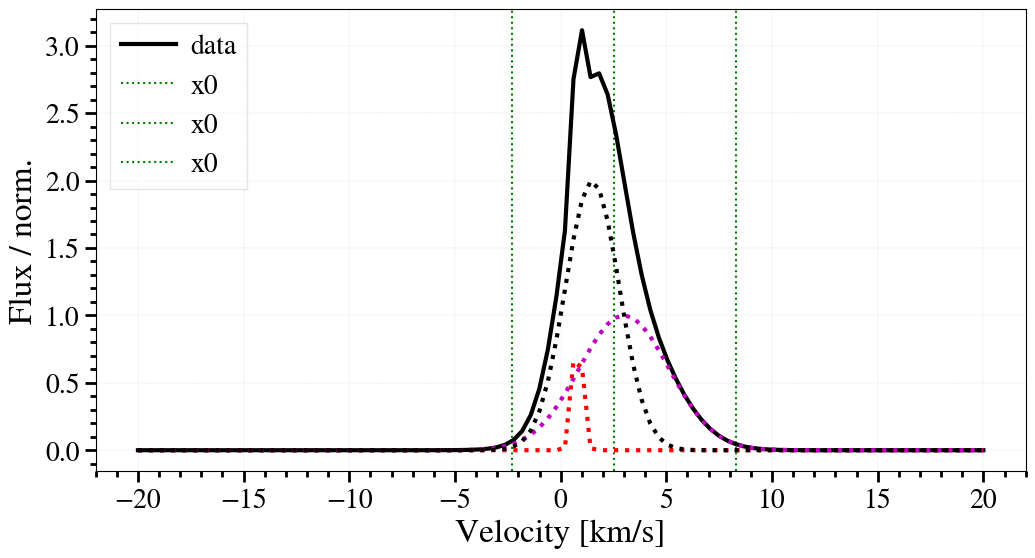

In [ ]:
# Plot
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

ax.plot(xaxis, blended_gaussian(xaxis, amp, xcen, width), 'k-', lw=3., label='data')
ax.plot(xaxis, gaussianfcn(xaxis, amp[0], xcen[0], width[0]), 'r:', lw=3., label='')
ax.plot(xaxis, gaussianfcn(xaxis, amp[1], xcen[1], width[1]), 'm:', lw=3., label='')
ax.plot(xaxis, gaussianfcn(xaxis, amp[2], xcen[2], width[2]), 'k:', lw=3., label='')

ax.axvline(x=x0, color='green', ls=':', zorder=-2, label='x0')
ax.axvline(x=x_min, color='green', ls=':', zorder=-2, label='x0')
ax.axvline(x=xmax, color='green', ls=':', zorder=-2, label='x0')

ax.set_xlabel(r'Velocity [km/s]', fontsize=24)
ax.set_ylabel(r'Flux / norm.', fontsize=24)


# Add axes labels
ax.minorticks_on()
ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)

# ax.set_xlim(-80, 80.)

# ax.set_ylim(, 80.)


ax.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)
leg = ax.legend(loc='upper left', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=20, handletextpad=0.5) # handletextpad=-2.0
# [item.set_visible(False) for item in leg.legend_handles]

# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.2,
                    hspace=0.3
                    )

# Save: spectra_eg.png
# plt.tight_layout()
plt.show()
plt.close()

# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [ ]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/gaia/
!ls

/content/gdrive/My Drive/Colab Notebooks/gaia
 a00_voigt_profiles_Gaussian_LSF.ipynb
 appendix_Figures_A1_A2.ipynb
'Copy of s03_figure_1.ipynb'
'Copy of s16_ki_ew_calc_3sigma.ipynb'
'Copy of s18_ki_ew_calc_3sigma_at_different_distances.ipynb'
 data
 figs
 GALAH_note
 index.html
 p01_vel_relation_ki_hi_462_los_both_Gaussian_fits_check_rv_comp_1.ipynb
 p02a_velocity_relation_ki_hi_462_los.ipynb
 p02_vel_relation_ki_hi_462_los_both_Gaussian_fits_check_rv_comp_1.ipynb
 README.txt
 s00a_read_galah_ISM_absorption_org.ipynb
 s00_read_galah_ISM_absorption.ipynb
 s01_GALAH_star_catalog.ipynb
 s01_read_galah_ISM_chamaeleon.ipynb
 s02_GALAH_KI_spectra_vs_HI_spectra.ipynb
 s02_read_galah_ISM_absorption_shell_thickness.ipynb
 s03a_read_galah_ISM_KI_absorption_vs_HI_absorption.ipynb
 s03_figure_1.ipynb
 s03_read_galah_ISM_KI_absorption_vs_HI_absorption.ipynb
 s04_ki_dib_ism_vs_hi_spectra.ipynb
 s04_Table_1.ipynb
 s05_figure_2_Vel_KI_vs_Vel_HI.ipynb
 s05_shell_thickness.ipynb
 s06a_local_bubble_Oneil

In [ ]:
! pwd

/content/gdrive/My Drive/Colab Notebooks/gaia


In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/gaia/data
!ls

/content/gdrive/My Drive/Colab Notebooks/gaia/data
140809004901206_allstar_fit_spectrum.fits2485oxlp.tmp
140809004901206_allstar_fit_spectrum.fitsgz5ulr4u.tmp
140809004901206_allstar_fit_spectrum.fitskv73mpff.tmp
all_gaskap_src_dust_spectra.npy
dib_gspspec_lambda.fits
dust3d
dustspecs
dust_spectra1
dust_spectra2
edenhofer
galah
galah_dr4_allstar_240705.fits
galah_dr4_vac_dynamics_240705.fits
galah_fg_df_3sigma.csv
galah_fg_df.csv
gaskap_abs_spectra_dr3b.csv
hires_result_CNM_components_dr3.csv
MC_GD_result_CNM_components_230726.csv
MC_GD_result_CNM_components.csv
MC_GD_result_CNM_components_extra_info.csv
nhi_thin_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits
oneill
result_table_dr3_integrated_properties.csv
smc
spectra_cham
stars_gl_250_270_gb_-46_-25.fits
stars_gl_270_310_gb_-65_-45.fits
stars_gl_270_310_gb_-90_-65.fits
stars_MC_fg.fits
stellar_params_catalog-1kpc.fits
Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits
THINGS


In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/gaia/data/oneill

/content/gdrive/My Drive/Colab Notebooks/gaia/data/oneill


# Download data

In [ ]:
if False:
  !wget -O galah_dr4_allstar_240705.fits https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/catalogs/galah_dr4_allstar_240705.fits

In [ ]:
if False:
  !wget -O galah_dr4_vac_dynamics_240705.fits https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/catalogs/galah_dr4_vac_dynamics_240705.fits

In [ ]:
if False:
    # !wget -O ONeill2024_LocalBubble_ShellProperties_A0.5.fits https://dataverse.harvard.edu/api/access/datafile/8943783
    !wget -O ONeill2024_LocalBubble_Shell_xyz.fits https://dataverse.harvard.edu/api/access/datafile/8955365

# Install

In [ ]:
# ! pip install healpy --quiet

In [ ]:
! pip install wget --quiet

  Preparing metadata (setup.py) ... done


# Libraries

In [ ]:
import os
import sys
import pickle

import time
import math
import copy

import wget

import numpy as np
import pandas as pd

from scipy.stats import binned_statistic_2d
from scipy import stats

from astropy.io import fits
from astropy.wcs import WCS
from astropy    import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
import astropy.constants as const

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable ## for Plotting L.O.S Samples
import matplotlib.gridspec as gridspec

import torch

from pathlib import Path

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [ ]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

print('Torch version: ', torch.__version__)
print('torch.version.cuda: ', torch.version.cuda)

print("Is CUDA enabled?",torch.cuda.is_available())

device:  cpu
device_count:  0
Torch version:  2.6.0+cu124
torch.version.cuda:  12.4
Is CUDA enabled? False


# Paths

In [ ]:
gaia_path = Path('/content/gdrive/MyDrive/Colab Notebooks/gaia/')
ml_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML')
gaskap_path = Path('/content/gdrive/MyDrive/Colab Notebooks/GASKAP')

ml_data_path = ml_path / 'data'
data_path = gaia_path / 'data'
dust_data_path = data_path / 'edenhofer'
gaskap_data_path = gaskap_path / 'data'

local_bubble_data_path = data_path / 'oneill'

gaskap_hires_data_path = gaskap_data_path / 'hires'
gaskap_hires_result_path = gaskap_hires_data_path / 'results'

# GASS_data_path = ml_data_path / 'GASS'
GASS_data_path = gaskap_data_path / 'GASS'

dynamics_file = data_path / 'galah_dr4_vac_dynamics_240705.fits'
allstar_file = data_path / 'galah_dr4_allstar_240705.fits'
gaia_catalog_file = data_path / 'stellar_params_catalog-1kpc.fits'
gaia_catalog_file = data_path / 'stars_MC_fg.fits'

In [ ]:
%cd /content/gdrive/MyDrive/Colab Notebooks/GASKAP

/content/gdrive/MyDrive/Colab Notebooks/GASKAP


# Fcn

In [ ]:
vlsr_sun = 15.17 # km/s, see Sven's paper GALAH DR4 https://arxiv.org/pdf/2409.19858 Section 7.2.2


# Create velocity range around the central velocity
velocity_range = np.linspace(-100., 100., 500)

# Define the Gaussian function
def gaussian(x, amp, center, std):
    return amp * np.exp(-(x - center)**2 / (2 * std**2))

In [ ]:
def plot_star_hi_abs(GASS_nhi_thin_map, glon_cnm, glat_cnm, glon_det, glat_det, hi_det_src_id, closest_coords_glon, closest_coords_glat):
    xlbs = 18
    tlbs = 16
    cmap = 'viridis'
    cmap = 'bwr'

    cm = mpl.colormaps['cool'] # winter, cool, hsv, jet


    # Plot
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection=w)

    # Display the moment map image
    im = ax.imshow(GASS_nhi_thin_map, cmap='gray')
    # ax.invert_yaxis()  # Flips the Y axis
    # ax.invert_xaxis()  # Flips the X axis


    # sct = ax.scatter(src_gl_LMC, src_gb_LMC, s=40, transform=ax.get_transform('galactic'),
    #            marker='s', c=noise_LMC_percent,
    #            cmap='jet',
    #            norm=mpl.colors.LogNorm(vmin=noise_LMC_percent_min, vmax=100.),
    #            label='MW')

    sct = ax.scatter(glon_cnm, glat_cnm, s=40, c=vcencnm, transform=ax.get_transform('galactic'),
              marker='o', cmap=cmap, # vmin=-10, vmax=10., # norm=mpl.colors.LogNorm(vmin=0.01, vmax=0.2), # vmin=0.01, vmax=0.06, # vmax=n_k_is.max(),
              label='HI absorption detections')
    ax.scatter(glon_det[hi_det_src_id], glat_det[hi_det_src_id], s=150, transform=ax.get_transform('galactic'), marker='x', c='c', alpha=0.8, label='Absorption L.O.S')
    ax.scatter(closest_coords_glon, closest_coords_glat, s=110, transform=ax.get_transform('galactic'), marker='*', c='magenta', alpha=0.8, label='Star')

    ax.plot(ch_xcirc, ch_ycirc,
            transform=ax.get_transform('galactic'),
            lw=3.5,
            c='lightcyan',
            ls='--',
            zorder=0,
            alpha=0.5,
            label='Horizontal filament'
          )

    ax.plot(cv_xcirc, cv_ycirc,
            transform=ax.get_transform('galactic'),
            lw=3.5,
            c='gray',
            ls='--',
            alpha=0.5,
            zorder=0,
            label='Vertical filament'
          )


    # Approximate locations of LMC, SMC
    ax.plot(SMC_xcirc,
            SMC_ycirc,
            transform=ax.get_transform('galactic'),
            lw=2.,
            color='r',
            ls='--',
            label='Toward SMC'
          )
    ax.plot(LMC_xcirc,
            LMC_ycirc,
            transform=ax.get_transform('galactic'),
            lw=2.,
            color='y',
            ls='--',
            label='Toward LMC'
          )



    # Title
    # ax.set_title(f"LMC: {n_fields} fields, {n_sightlines} sources", fontsize=18)

    # Add axes labels
    ax.set_xlabel('Galactic Longitude [degrees]', fontsize=xlbs)
    ax.set_ylabel('Galactic Latitude [degrees]', fontsize=xlbs)

    # Add a colorbar
    # cbar = plt.colorbar(im, pad=.07)
    # cbar.set_label('Velocity (km/s)', size=16)

    # Color bar
    cbar = fig.colorbar(sct, ax=ax, orientation='vertical', fraction=0.01, pad=0.006, aspect=55)
    cbar.ax.set_ylabel('CNM Velocity [km/s]', rotation=90, labelpad=5., fontsize=15)
    cbar.ax.tick_params(labelsize=16)

    # Overlay set of RA/Dec Axes
    # overlay = ax.get_coords_overlay('fk5')
    # overlay.grid(color='white', ls='dotted', lw=0.3)
    # overlay[0].set_axislabel('Right Ascension (J2000)', fontsize=16)
    # overlay[1].set_axislabel('Declination (J2000)', fontsize=16)

    # Overplot column density contours
    # levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22)  # Define contour levels to use
    # ax.contour(NHI.hdu.data, cmap='Greys_r', alpha=0.5, levels=levels)

    ax.minorticks_on()
    ax.tick_params(axis='x', labelsize=tlbs, pad=4)
    ax.tick_params(axis='y', labelsize=tlbs)
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=4)


    ax.legend(loc='upper left', fontsize=16)

    plt.grid(color='gray', lw=0.5)
    plt.show()

In [ ]:
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def download_galah_data(save_path, sobject_id):
    sobject_id = str(sobject_id)
    output_star_id_file = save_path / f'{sobject_id}_allstar_fit_spectrum.fits'
    # print(output_star_id_file)
    save_path = str(save_path)

    if not os.path.exists(output_star_id_file):
        url = f'https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/{sobject_id[:6]}/{sobject_id}/{sobject_id}_allstar_fit_spectrum.fits'
        wget.download(url, out=save_path)

        url = f'https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/{sobject_id[:6]}/{sobject_id}/{sobject_id}_allstar_fit_comparison.pdf'
        wget.download(url, out=save_path)

In [ ]:
def rv_to_lsr(ra, dec, rv, u_sun=11.10, v_sun=12.24, w_sun=7.25):
    """
    Convert heliocentric radial velocities to the Local Standard of Rest (LSR).

    Parameters:
    -----------
    ra : float or array-like
        Right Ascension in degrees
    dec : float or array-like
        Declination in degrees
    rv : float or array-like
        Heliocentric radial velocity in km/s
    u_sun : float, optional
        Solar motion in km/s toward the Galactic center
    v_sun : float, optional
        Solar motion in km/s in direction of Galactic rotation
    w_sun : float, optional
        Solar motion in km/s toward the North Galactic Pole

    Returns:
    --------
    float or array-like
        Radial velocity in the LSR frame in km/s
    """
    # Create SkyCoord object
    coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')

    # Convert to Galactic coordinates
    l = coords.galactic.l.radian
    b = coords.galactic.b.radian

    # Calculate projection of solar motion
    proj_sun_vel = (
        u_sun * np.cos(b) * np.cos(l) +
        v_sun * np.cos(b) * np.sin(l) +
        w_sun * np.sin(b)
    )

    # Convert to LSR
    rv_lsr = rv + proj_sun_vel

    return rv_lsr







def rv_to_lsr_lb(glon, glat, rv, u_sun=11.10, v_sun=12.24, w_sun=7.25):
    """
    Convert heliocentric radial velocities to the Local Standard of Rest (LSR).

    Schönrich et al. (2010): https://academic.oup.com/mnras/article/403/4/1829/1054839
    and https://www.aanda.org/articles/aa/pdf/2024/09/aa50936-24.pdf

    Parameters:
    -----------
    glon : float or array-like
        Galactic longitude in degrees
    glat : float or array-like
        Galactic latitude in degrees
    rv : float or array-like
        Heliocentric radial velocity in km/s
    u_sun : float, optional
        Solar motion in km/s toward the Galactic center
    v_sun : float, optional
        Solar motion in km/s in direction of Galactic rotation
    w_sun : float, optional
        Solar motion in km/s toward the North Galactic Pole

    Returns:
    --------
    float or array-like
        Radial velocity in the LSR frame in km/s
    """
    # Convert to Galactic coordinates
    l = np.radians(glon)
    b = np.radians(glat)

    # Calculate projection of solar motion
    proj_sun_vel = (
        u_sun * np.cos(b) * np.cos(l) +
        v_sun * np.cos(b) * np.sin(l) +
        w_sun * np.sin(b)
    )

    # Convert to LSR
    rv_lsr = rv + proj_sun_vel

    return rv_lsr

In [ ]:
def wavelength_to_rv(wavelength_obs, wavelength_rest):
    """
    Calculate radial velocity from observed and rest wavelengths using the
    relativistic Doppler formula.

    Parameters:
    -----------
    wavelength_obs : float or array-like
        Observed wavelength(s) in Angstroms
    wavelength_rest : float
        Rest wavelength in Angstroms

    Returns:
    --------
    float or array-like
        Radial velocity in km/s (positive values indicate redshift/receding motion)
    """
    # Convert wavelengths to float if they're strings
    wavelength_obs = np.float64(wavelength_obs)
    wavelength_rest = np.float64(wavelength_rest)

    # Calculate velocity using relativistic formula
    c = const.c.to('km/s').value  # speed of light in km/s

    # (λ_obs / λ_rest)^2 = (1 + v/c)/(1 - v/c)
    # Solving for v:
    z = wavelength_obs / wavelength_rest
    rv = c * (z**2 - 1) / (z**2 + 1)

    return rv

def wavelength_to_rv_simple(wavelength_obs, wavelength_rest):
    """
    Calculate radial velocity using the simple (non-relativistic) Doppler formula.
    Use this only for v << c.

    Parameters:
    -----------
    wavelength_obs : float or array-like
        Observed wavelength(s) in Angstroms
    wavelength_rest : float
        Rest wavelength in Angstroms

    Returns:
    --------
    float or array-like
        Radial velocity in km/s (positive values indicate redshift/receding motion)
    """
    c = const.c.to('km/s').value  # speed of light in km/s

    # Simple Doppler formula: v/c = Δλ/λ
    # rv = c * (wavelength_obs - wavelength_rest) / wavelength_rest
    rv = c * (wavelength_obs - wavelength_rest) / wavelength_obs

    return rv

In [ ]:
def wavelength_to_vlsrk(observed_wavelengths, rest_wavelength, galactic_l, galactic_b, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25):
    """
    Converts observed wavelengths to VLSRK (velocity relative to the LSR) using the radio convention.

    Args:
        observed_wavelengths (array-like): Array of observed wavelengths (in Angstroms or nanometers).
        rest_wavelength (float): Rest wavelength of the spectral line (in the same units as observed_wavelengths).
        galactic_l (float): Galactic longitude (in degrees).
        galactic_b (float): Galactic latitude (in degrees).
        u_lsr (float, optional): LSR velocity component towards the Galactic Center (km/s).
        v_lsr (float, optional): LSR velocity component in the direction of Galactic rotation (km/s).
        w_lsr (float, optional): LSR velocity component perpendicular to the Galactic plane (km/s).

    Returns:
        numpy.ndarray: Array of VLSRK velocities (in km/s).
    """

    c = const.c.to('km/s').value  # Speed of light in km/s

    observed_wavelengths = np.array(observed_wavelengths)

    # 1. Radial Velocity (Vrad) using radio convention
    vrad = c * (1 - rest_wavelength / observed_wavelengths)

    # 2. Heliocentric Velocity (Vhelio)
    # This requires more information about the observation time and location,
    # and the earth's velocity. For simplicity, we are skipping this part.
    # In practice, you would use astropy.coordinates.EarthLocation and astropy.time.Time,
    # to accurately get the earth's velocity.
    # For now, we are assuming Vhelio = Vrad. Therefore, the result will be slightly off.
    vhelio = vrad

    # 3. VLSRK
    l_rad = np.radians(galactic_l)
    b_rad = np.radians(galactic_b)

    vlsrk = vhelio + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)

    return vlsrk


# vlsrk_velocities = wavelength_to_vlsrk(observed_wavelengths_angstroms, rest_wavelength_angstroms, galactic_l, galactic_b)

In [ ]:
def wavelength_to_vlsrk_with_galah_correction(observed_wavelengths, rest_wavelength, galactic_l, galactic_b, rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25):
    """
    Converts observed wavelengths to VLSRK (velocity relative to the LSR) using the radio convention.

    Args:
        observed_wavelengths (array-like): Array of observed wavelengths (in Angstroms or nanometers).
        rest_wavelength (float): Rest wavelength of the spectral line (in the same units as observed_wavelengths).
        galactic_l (float): Galactic longitude (in degrees).
        galactic_b (float): Galactic latitude (in degrees).
        galah_allstar['rv_comp_1']: See GALAH
        u_lsr (float, optional): LSR velocity component towards the Galactic Center (km/s).
        v_lsr (float, optional): LSR velocity component in the direction of Galactic rotation (km/s).
        w_lsr (float, optional): LSR velocity component perpendicular to the Galactic plane (km/s).

    Returns:
        numpy.ndarray: Array of VLSRK velocities (in km/s).
    """

    c = const.c.to('km/s').value  # Speed of light in km/s

    observed_wavelengths = np.array(observed_wavelengths)

    # 1. Radial Velocity (Vrad) using radio convention
    vrad = c * (1. - rest_wavelength / observed_wavelengths) + rv_comp_1
    # vrad = c * (1. - rest_wavelength/observed_wavelengths)

    # 2. Heliocentric Velocity (Vhelio)
    # This requires more information about the observation time and location,
    # and the earth's velocity. For simplicity, we are skipping this part.
    # In practice, you would use astropy.coordinates.EarthLocation and astropy.time.Time,
    # to accurately get the earth's velocity.
    # For now, we are assuming Vhelio = Vrad. Therefore, the result will be slightly off.
    # vhelio = vrad

    # 3. VLSRK
    l_rad = np.radians(galactic_l)
    b_rad = np.radians(galactic_b)

    # vlsrk = vhelio + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)
    vlsrk = vrad + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)

    return vlsrk


# vlsrk_velocities = wavelength_to_vlsrk(observed_wavelengths_angstroms, rest_wavelength_angstroms, galactic_l, galactic_b)

In [ ]:
def binned_avg(x: np.ndarray, y: np.ndarray, bin_edges: np.ndarray, n_resamples = 1000):
    from scipy import stats

    # Calculate the bin average using scipy
    bin_avg, _, _ = stats.binned_statistic(x, y, statistic='mean', bins=bin_edges)

    # Container for bin averages
    bin_avg_arr = []

    # Perform bootstrap resampling and calculate bin averages
    for _ in range(n_resamples):
        resample_indices = np.random.choice(len(y), size=len(y), replace=True)
        resample_y= y[resample_indices]
        bin_avg_resample, _, _ = stats.binned_statistic(x, resample_y, statistic='mean', bins=bin_edges)
        bin_avg_arr.append(bin_avg_resample)

    # Compute the upper and lower percentiles of the bin averages
    bin_avg_arr = np.array(bin_avg_arr)
    bin_mean_arr = np.mean(bin_avg_arr, axis=0)
    bin_avg_upper = np.percentile(bin_avg_arr, 97.5, axis=0) - bin_mean_arr + bin_avg
    bin_avg_lower = np.percentile(bin_avg_arr, 2.5, axis=0) - bin_mean_arr + bin_avg

    return bin_avg, bin_avg_upper, bin_avg_lower

In [ ]:
# Define the Gaussian function with FWHM
def gaussian(x, A, x0, FWHM):
    sigma = FWHM / 2.3548
    return A * np.exp(-(x-x0)**2 / (2*sigma**2))

In [ ]:
def normalize_spectrum(spectrum):
    min_val = np.min(spectrum)
    max_val = np.max(spectrum)

    # Handle the case where all values are the same
    if max_val == min_val:
        return np.zeros_like(spectrum)  # Return a spectrum of zeros or any consistent value

    # Apply min-max normalization
    normalized_spectrum = (spectrum - min_val) / (max_val - min_val)
    return normalized_spectrum

In [ ]:
def compute_column_density_KI(W_lambda_angstrom):
    """
    Compute the column density for weak lines:

    \[
    W_{\lambda} = \frac{\pi e^2}{m_e c^2} f \lambda^2 N
    \]

    Where:

    - \( e \) is the electron charge
    - \( m_e \) is the electron mass
    - \( c \) is the speed of light
    - \( f \) is the oscillator strength of the transition
    - \( \lambda \) is the wavelength of the line

    """
    # f = 0.3393  # Oscillator strength
    f = 0.332 # Oscillator strength
    lambda_ = 7698.9643 * u.Angstrom  # Wavelength in Angstrom lambda_rest = 7698.9643 # Angstroms

    # Convert equivalent width from Angstrom to meters
    W_lambda_m = (W_lambda_angstrom * u.Angstrom).to(u.m)

    # Compute column density using the formula
    N = (W_lambda_m * const.m_e * const.c**2) / (np.pi * const.e.gauss**2 * f * lambda_.to(u.m)**2)

    return N.to(10**(10)/u.cm**2)  # This ensures the column density is returned in SI units (m^-2)

In [ ]:
def mollweide_histogram(ra, dec, distance, eq_width, bin_size=1000, nside=32):
    """
    Plots a histogram in Mollweide projection using HEALPix binning that shows the median
    equivalent width for bins of distances, in galactic coordinates.

    Parameters:
    - ra (array): Right ascension in degrees.
    - dec (array): Declination in degrees.
    - distance (array): Distance in parsec.
    - eq_width (array): Equivalent width in Å.
    - bin_size (int, optional): The size of the distance bins. Default is 200 parsecs.
    - nside (int, optional): The resolution of the HEALPix map. Default is 32.
    """
    # Convert equatorial coordinates (RA, Dec) to galactic coordinates (l, b)
    c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    l = c.galactic.l.degree
    b = c.galactic.b.degree

    # Convert (l, b) to HEALPix indices
    indices = hp.ang2pix(nside, l, b, lonlat=True)

    # Get maximum distance for binning
    max_dist = np.max(distance)

    # Create bins for distances
    bins = np.arange(0, max_dist + bin_size, bin_size)

    for i in range(len(bins) - 1)[:2]:
        mask = (distance >= 0) & (distance < bins[i+1])
        if np.any(mask):
            median_map = np.full(hp.nside2npix(nside), np.nan)
            for ind in np.unique(indices[mask]):
                median_map[ind] = np.median(eq_width[(indices == ind) & mask])

            hp.mollview(
                median_map,
                title=f'N(KI) 7699',
                cmap='plasma',
                min=7,max=21,
                badcolor='None',
                bgcolor='None',
                unit = r'N(KI) 7699 / $10^{10}\,\mathrm{cm^{-2}}$'
            )
            hp.graticule()

            plt.savefig('figures/n_k_'+str(i)+'.png',dpi=200,bbox_inches='tight', transparent=True)
            plt.show()
            plt.close()

In [ ]:
def create_parallel_uncertainty_lines(x, y, x_err, confidence=0.95):
    """
    Create uncertainty envelope by plotting the outermost lines on both sides of the 1:1 line.

    Parameters:
    -----------
    x : array-like
        X values of data points
    y : array-like
        Y values of data points
    x_err : array-like
        Error values for X data points
    confidence : float, default=0.95
        Confidence level for the envelope (0-1)
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, if None, a new figure is created

    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure containing the plot
    ax : matplotlib.axes.Axes
        Axes containing the plot
    """

    # Convert inputs to numpy arrays
    x = np.array(x)
    y = np.array(y)
    x_err = np.array(x_err)

    # Calculate z-score for the given confidence level
    z = stats.norm.ppf((1 + confidence) / 2)

    # Sort data by x values for proper line creation
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    x_err_sorted = x_err[sort_idx]

    # For visualizing the envelope boundaries, create extended x range
    x_min = min(x_sorted - x_err_sorted)
    x_max = max(x_sorted + x_err_sorted)
    extension = (x_max - x_min) * 0.1  # Extend by 10% on each side
    x_extended = np.array([x_min - extension, x_max + extension])

    # Calculate the maximum positive deviation from 1:1 line
    max_positive_dev = max(y_sorted - x_sorted + z * x_err_sorted)

    # Calculate the maximum negative deviation from 1:1 line
    max_negative_dev = min(y_sorted - x_sorted - z * x_err_sorted)

    # Create the upper and lower boundary lines that are parallel to the 1:1 line
    y_upper = x_extended + max_positive_dev
    y_lower = x_extended + max_negative_dev

    return x_extended, y_lower, y_upper

In [ ]:
def get_angular_distance(glon_src, glat_src, star_glon, star_glat):
    """
    Find stars within a specified angular radius of a source position in Galactic coordinates.

    Parameters:
    -----------
    glon_src : float
        Galactic longitude of the source in degrees
    glat_src : float
        Galactic latitude of the source in degrees
    stars_glon : array-like
        Galactic longitudes of stars in degrees
    stars_glat : array-like
        Galactic latitudes of stars in degrees
    star_ids : array-like
        Identifiers for each star

    Returns:
    --------
    nearby_ids : numpy array
        IDs of stars within the search radius
    nearby_coords : dict
        Dictionary containing coordinates and distances of nearby stars:
        - 'glon': Galactic longitudes
        - 'glat': Galactic latitudes
        - 'distances': Angular distances in degrees
    """

    # Convert everything to radians for spherical trig calculations
    glon_src_rad = np.radians(glon_src)
    glat_src_rad = np.radians(glat_src)
    star_glon_rad = np.radians(star_glon)
    star_glat_rad = np.radians(star_glat)

    # Use the spherical law of cosines to find angular distances
    # cos(c) = sin(lat1)sin(lat2) + cos(lat1)cos(lat2)cos(lon1-lon2)
    angular_distance_rad = np.arccos(
        np.sin(glat_src_rad) * np.sin(star_glat_rad) +
        np.cos(glat_src_rad) * np.cos(star_glat_rad) *
        np.cos(glon_src_rad - star_glon_rad)
    )

    # Convert distances back to degrees
    angular_distance = np.degrees(angular_distance_rad)

    return angular_distance

In [ ]:
def find_nearby_stars(glon_src, glat_src, stars_glon, stars_glat, star_ids, radius_deg):
    """
    Find stars within a specified angular radius of a source position in Galactic coordinates.

    Parameters:
    -----------
    glon_src : float
        Galactic longitude of the source in degrees
    glat_src : float
        Galactic latitude of the source in degrees
    stars_glon : array-like
        Galactic longitudes of stars in degrees
    stars_glat : array-like
        Galactic latitudes of stars in degrees
    star_ids : array-like
        Identifiers for each star
    radius_deg : float
        Search radius in degrees

    Returns:
    --------
    nearby_ids : numpy array
        IDs of stars within the search radius
    nearby_coords : dict
        Dictionary containing coordinates and distances of nearby stars:
        - 'glon': Galactic longitudes
        - 'glat': Galactic latitudes
        - 'distances': Angular distances in degrees
    """

    # Convert everything to radians for spherical trig calculations
    glon_src_rad = np.radians(glon_src)
    glat_src_rad = np.radians(glat_src)
    stars_glon_rad = np.radians(stars_glon)
    stars_glat_rad = np.radians(stars_glat)
    radius_rad = np.radians(radius_deg)

    # Use the spherical law of cosines to find angular distances
    # cos(c) = sin(lat1)sin(lat2) + cos(lat1)cos(lat2)cos(lon1-lon2)
    angular_distances_rad = np.arccos(
        np.sin(glat_src_rad) * np.sin(stars_glat_rad) +
        np.cos(glat_src_rad) * np.cos(stars_glat_rad) *
        np.cos(glon_src_rad - stars_glon_rad)
    )

    # Convert distances back to degrees
    angular_distances = np.degrees(angular_distances_rad)

    # Create boolean mask for stars within radius
    mask = angular_distances < radius_deg

    # Collect results for nearby stars
    nearby_coords = {
        'glon': stars_glon[mask],
        'glat': stars_glat[mask],
        'distances': angular_distances[mask],
        'ki_ew_ism': galah['ew_k_is'][mask]
    }

    nearby_ids = star_ids[mask]

    return nearby_ids, nearby_coords

# For plotting

In [ ]:

# Circle
def _circle(x, y, r):
    theta = np.linspace(0, 2*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_LMC = 279.
gb_LMC = -33.5
R_LMC = 5.

gl_SMC = 302.
gb_SMC = -44.5
R_SMC = 3.

LMC = dict(
    gl = gl_LMC,
    gb = gb_LMC,
    center = [gl_LMC, gb_LMC],
    glon_range = [270., 307.],
    glat_range = [-48., -25.],
    circ = _circle(gl_LMC, gb_LMC, R_LMC),
    name = 'Large Magellanic Cloud'
)


SMC = dict(
    gl = gl_SMC,
    gb = gb_SMC,
    center = [gl_SMC, gb_SMC],
    glon_range = [295., 315.],
    glat_range = [-50., -40.],
    circ = _circle(gl_SMC, gb_SMC, R_SMC),
    name = 'Small Magellanic Cloud'
)

# SMC_xcirc = _circle(305., -41, 3.),
# LMC_xcirc = _circle(277., -33.5, 6.)






# Approximate locations of LMC and SMC
SMC_xcirc, SMC_ycirc = SMC['circ']
LMC_xcirc, LMC_ycirc = LMC['circ']

# Circle
def hcircle(x, y, r):
    theta = np.linspace(1.365*np.pi, 1.55*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

# Circle
def vcircle(x, y, r):
    theta = np.linspace(1.73*np.pi, 1.87*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_ch = 295.
gb_ch = 21.8
R_ch = 59.

gl_cv = 238.
gb_cv = -5.
R_cv = 57.


ch_xcirc, ch_ycirc = hcircle(gl_ch, gb_ch, R_ch)
cv_xcirc, cv_ycirc = vcircle(gl_cv, gb_cv, R_cv)

# glon = np.arange(270., 307., 0.1)
# glat = np.arange(-48., -25., 0.1)
lmc_glon = [270., 308.]
lmc_glat = [-48.99, -26.45]

# lmc_glon = [270., 309.]
# lmc_glat = [-48.25, -26.95]

gl_boundary = np.array([297., 302., 305., 308., 305., 297., 298., 295., 292., 294., 285., 283.5, 271.5, 271., 288.5, 290., 295., 297.])
gb_boundary = np.array([-36., -35., -40., -42.5, -48.5, -46.2, -43., -38.25, -39.8, -44.5, -45.9, -40.8, -41.5, -29., -26.9, -32., -31., -36.])

# Read GASKAP-HI absorption measurements: Pilot II data (all)

In [ ]:
hi_abs_all_filename = gaskap_hires_data_path / 'absdr3' / 'gaskap_abs_spectra_dr3b.csv'
print(hi_abs_all_filename)

abs_df = pd.read_csv(hi_abs_all_filename)
nmes, _ = abs_df.shape
print(f'Number of all sources {nmes}')
abs_df.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/absdr3/gaskap_abs_spectra_dr3b.csv
Number of all sources 2714


id       comp_name          component_id         ra        dec        glon  \
0   0  J005611-710706  SB30665_component_1a  14.047482 -71.118446  302.378462   
1   8  J011049-731427  SB30665_component_3a  17.707468 -73.240921  300.996592   
2   9  J011056-731406  SB30665_component_3b  17.735945 -73.235151  300.984436   
3  10  J004048-714600  SB30665_component_4a  10.200474 -71.766489  304.115161   
4  11  J005732-741242  SB30665_component_5a  14.385728 -74.211897  302.365011   

        glat rating   flux_peak    flux_int  ...  semi_min_axis          pa  \
0 -46.004698      A  519.130005  442.507996  ...          4.215   33.869999   
1 -43.814386      A  457.480988  596.744995  ...          5.350   54.860001   
2 -43.819266      A  115.037003  208.171005  ...          5.745   39.880001   
3 -45.337319      A  428.450012  463.325989  ...          4.905  175.600006   
4 -42.909634      A  428.031006  461.653015  ...          4.895  175.509995   

            n_h  noise_flag  continuum_slope    field  all_sbids   sbid  \
0  1.236612e+21       False         0.000923  M344-11      30665  30665   
1  4.874624e+21       False        -0.000770  M344-11      30665  30665   
2  4.874624e+21       False        -0.000363  M344-11      30665  30665   
3  4.498524e+20       False         0.000679  M344-11      30665  30665   
4  5.650006e+20       False         0.000971  M344-11      30665  30665   

   mw_detection  saturated  
0          True      False  
1          True      False  
2         False      False  
3          True      False  
4          True      False  

[5 rows x 33 columns]

In [ ]:
non_hiabs_df = abs_df[abs_df.mw_detection == False]
non_hiabs_df

id       comp_name            component_id         ra        dec  \
2      9  J011056-731406    SB30665_component_3b  17.735945 -73.235151   
8     24  J004327-704135   SB30665_component_11a  10.863942 -70.693260   
10    26  J013229-723956   SB30665_component_12a  23.123198 -72.665757   
11    28  J002919-754018   SB30665_component_13a   7.330447 -75.671738   
12    29  J002920-754008   SB30665_component_13b   7.334793 -75.668999   
...   ..             ...                     ...        ...        ...   
2709   0  J045631-762533  SB38845_component_245a  74.132371 -76.425960   
2710   0  J045907-753153  SB38845_component_261a  74.779860 -75.531478   
2711   0  J045340-751015  SB38758_component_264a  73.419855 -75.170876   
2712   0  J060302-715904  SB33047_component_273a  90.760142 -71.984682   
2713   0  J051901-715032  SB33047_component_266a  79.756674 -71.842486   

            glon       glat rating   flux_peak    flux_int  ...  \
2     300.984436 -43.819266      A  115.037003  208.171005  ...   
8     303.888848 -46.420157      B  215.136993  332.138000  ...   
10    298.690805 -44.122841      B  138.602005  138.981995  ...   
11    304.752927 -41.378221      B  185.477005  206.205994  ...   
12    304.751919 -41.381065      B   70.438004   70.567001  ...   
...          ...        ...    ...         ...         ...  ...   
2709  288.737278 -32.932020      C   18.582001   20.014000  ...   
2710  287.674258 -33.105855      C   17.294001   21.070000  ...   
2711  287.418567 -33.556039      C   15.995000   17.537001  ...   
2712  282.615941 -29.427549      C   16.532000   17.809999  ...   
2713  282.987430 -32.826949      B   16.945999   26.240000  ...   

      semi_min_axis          pa           n_h  noise_flag  continuum_slope  \
2             5.745   39.880001  4.874624e+21       False        -0.000363   
8             5.895  131.210007  2.227711e+20       False         0.000643   
10            4.800  127.029999  1.083733e+21       False         0.002100   
11            4.860    7.050000  1.705849e+20       False         0.002592   
12            4.735  156.479996  1.705849e+20       False         0.000732   
...             ...         ...           ...         ...              ...   
2709          4.195   40.980000  0.000000e+00       False        -0.001994   
2710          4.570   51.529999  0.000000e+00       False        -0.000745   
2711          4.195   57.150002  0.000000e+00       False         0.004325   
2712          3.845   84.059998  0.000000e+00       False        -0.017450   
2713          4.735  110.529999  0.000000e+00       False         0.005653   

        field    all_sbids   sbid  mw_detection  saturated  
2     M344-11        30665  30665         False      False  
8     M344-11        30665  30665         False      False  
10    M344-06        30665  30665         False      False  
11    M344-11        30665  30665         False      False  
12    M344-11        30665  30665         False      False  
...       ...          ...    ...           ...        ...  
2709  M000-02  38509,38845  38845         False      False  
2710  M000-02  38758,38845  38845         False      False  
2711  M000-02  38758,38845  38758         False      False  
2712  M000-02  33047,38845  33047         False      False  
2713  M000+02  33047,38845  33047         False      False  

[2252 rows x 33 columns]

In [ ]:
# non_hiabs_srcs = non_hiabs_df['comp_name'].values
# non_hiabs_srcs

# Read GASKAP-HI absorption MW foreground: Pilot II data (detection)

In [ ]:
spectra_filename = gaskap_hires_result_path / 'result_table_dr3_integrated_properties.csv'
print(spectra_filename)
df_det = pd.read_csv(spectra_filename)
ndet, ncols = df_det.shape
print(f'Number of rows {ndet},\n Number of columns: {ncols}')
df_det.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results/result_table_dr3_integrated_properties.csv
Number of rows 462,
 Number of columns: 45


comp_name   sbid             uniq_name        ra        dec  \
0  J001424-733911  30665  J001424-733911-30665  3.601159 -73.653109   
1  J002144-741500  30665  J002144-741500-30665  5.433208 -74.249829   
2  J002223-742825  30665  J002223-742825-30665  5.597676 -74.473760   
3  J002248-734007  30665  J002248-734007-30665  5.700254 -73.668709   
4  J002335-735529  30665  J002335-735529-30665  5.895892 -73.924770   

         glon       glat  in_bridge rating   flux_peak  ...  sigRfactor  \
0  306.494335 -43.218047          0      A  184.315994  ...    0.123268   
1  305.669096 -42.720187          0      B  122.134003  ...    0.139190   
2  305.562542 -42.505801          0      B  103.077003  ...    0.093871   
3  305.692177 -43.305728          0      B   49.626999  ...    0.084394   
4  305.565463 -43.060758          0      B   62.061001  ...    0.093914   

        nhi    signhi  nhi_thin  signhi_thin  ncnm      tsky    flux_int  \
0  2.730491  0.297817  2.646857     0.110566     2  3.555342  179.488998   
1  3.164146  0.399856  3.152547     0.179060     2  3.561425  132.397995   
2  2.909353  0.249468  2.823752     0.085782     2  3.561425  206.740997   
3  3.155461  0.213848  2.971679     0.125477     1  3.564467   49.803001   
4  2.635446  0.234640  2.824470     0.128897     1  3.567508   61.556000   

      ra_hr  tau_noise_per_channel  
0  0.240077               0.014621  
1  0.362214               0.028466  
2  0.373178               0.019057  
3  0.380017               0.057622  
4  0.393059               0.018767  

[5 rows x 45 columns]

In [ ]:
df_det[(df_det.glon > 298.) & (df_det.glon < 299.5) & (df_det.glat < -35.) & (df_det.glat > -37.) ]

comp_name   sbid             uniq_name         ra        dec  \
84  J020448-795503  38215  J020448-795503-38215  31.203087 -79.917777   

          glon       glat  in_bridge rating  flux_peak  ...  sigRfactor  \
84  298.994627 -36.643042          1      A    208.112  ...    0.053828   

         nhi    signhi  nhi_thin  signhi_thin  ncnm      tsky    flux_int  \
84  5.838456  0.258346   5.43144     0.118902     2  3.509719  427.169006   

       ra_hr  tau_noise_per_channel  
84  2.080206               0.017692  

[1 rows x 45 columns]

In [ ]:
df_det.columns

Index(['comp_name', 'sbid', 'uniq_name', 'ra', 'dec', 'glon', 'glat',
       'in_bridge', 'rating', 'flux_peak', 'mean_cont', 'sd_cont',
       'opacity_range', 'max_s_max_n', 'max_noise', 'num_chan_noise',
       'semi_maj_axis', 'semi_min_axis', 'pa', 'min_opacity',
       'vel_min_opacity', 'peak_tau', 'e_peak_tau', 'n_h', 'ew', 'sigew',
       'ewfit', 'sigewfit', 'nhicnm', 'signhicnm', 'nhiwnm', 'signhiwnm',
       'fcnm', 'sigfcnm', 'Rfactor', 'sigRfactor', 'nhi', 'signhi', 'nhi_thin',
       'signhi_thin', 'ncnm', 'tsky', 'flux_int', 'ra_hr',
       'tau_noise_per_channel'],
      dtype='object')

In [ ]:
glon_det = df_det['glon'].values
glat_det = df_det['glat'].values

In [ ]:
df_det[df_det['comp_name'] == 'J044512-654707']

comp_name   sbid             uniq_name        ra        dec  \
278  J044512-654707  38373  J044512-654707-38373  71.30335 -65.785523   

           glon       glat  in_bridge rating   flux_peak  ...  sigRfactor  \
278  276.844078 -37.365553          0      B  131.518005  ...     0.03444   

          nhi    signhi  nhi_thin  signhi_thin  ncnm      tsky    flux_int  \
278  3.180426  0.095409  3.155735     0.051061     1  3.293769  145.298004   

        ra_hr  tau_noise_per_channel  
278  4.753557               0.031312  

[1 rows x 45 columns]

In [ ]:
# vcencnm = df_det['cencnm'].values
# vcencnm

In [ ]:
print(gaskap_hires_data_path)
gaskap_hires_result_path

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires


PosixPath('/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results')

In [ ]:
gaskap_hires_result_path.exists()

True

# Read GASKAP-HI absorption CNM components

In [ ]:
cnm_filename = data_path / 'hires_result_CNM_components_dr3.csv'
print(cnm_filename)
df_cnm = pd.read_csv(cnm_filename)
nrows, ncols = df_cnm.shape
print(f'Number of rows {nrows},\n Number of columns: {ncols}')
df_cnm.head(5)

/content/gdrive/MyDrive/Colab Notebooks/gaia/data/hires_result_CNM_components_dr3.csv
Number of rows 691,
 Number of columns: 39


comp_name   sbid             uniq_name         ra        dec  \
0  J005611-710706  30665  J005611-710706-30665  14.047482 -71.118446   
1  J011049-731427  30665  J011049-731427-30665  17.707468 -73.240921   
2  J011049-731427  30665  J011049-731427-30665  17.707468 -73.240921   
3  J004048-714600  30665  J004048-714600-30665  10.200474 -71.766489   
4  J005732-741242  30665  J005732-741242-30665  14.385728 -74.211897   

         glon       glat  in_bridge rating   flux_peak  ...  sigtbcnm  \
0  302.378462 -46.004698          0      A  519.130005  ...  0.492912   
1  300.996592 -43.814386          0      A  457.480988  ...  1.093266   
2  300.996592 -43.814386          0      A  457.480988  ...  1.093266   
3  304.115161 -45.337319          0      A  428.450012  ...  0.809774   
4  302.365011 -42.909634          0      A  428.031006  ...  0.643373   

   nhicnm_cpn  signhicnm_cpn  fcnm_cpn  sigfcnm_cpn   nhi_tot  signhi_tot  \
0    0.258148       0.017671  0.115614     0.009510  2.232849    0.101853   
1    0.528091       0.061311  0.191089     0.029765  2.763580    0.286976   
2    0.145281       0.054101  0.052570     0.020323  2.763580    0.286976   
3    1.038635       0.153567  0.348299     0.109031  2.982020    0.822799   
4    0.359050       0.038501  0.131218     0.015583  2.736283    0.139665   

       tsky  nhicnm_avg  signhicnm_avg  
0  3.543176    0.246904       0.023536  
1  3.573591    0.526199       0.077868  
2  3.573591    0.144746       0.066422  
3  3.564467    1.031687       0.194750  
4  3.485386    0.356473       0.053406  

[5 rows x 39 columns]

In [ ]:
glon_cnm = df_cnm['glon'].values
glat_cnm = df_cnm['glat'].values

In [ ]:
vcencnm = df_cnm['cencnm'].values
vcencnm.shape

(691,)

In [ ]:
df_cnm[df_cnm['cencnm'] < -15.]

comp_name   sbid             uniq_name        ra        dec  \
51  J044512-654707  38373  J044512-654707-38373  71.30335 -65.785523   

          glon       glat  in_bridge rating   flux_peak  ...  sigtbcnm  \
51  276.844078 -37.365553          0      B  131.518005  ...  0.534026   

    nhicnm_cpn  signhicnm_cpn  fcnm_cpn  sigfcnm_cpn   nhi_tot  signhi_tot  \
51    0.329702       0.019492  0.103666     0.006873  3.180426    0.095409   

        tsky  nhicnm_avg  signhicnm_avg  
51  3.293769    0.328933       0.038879  

[1 rows x 39 columns]

# Oneill 2024 Local Bubble XYZ

In [ ]:
bubble_file = local_bubble_data_path / 'ONeill2024_LocalBubble_Shell_xyz.fits'
print(bubble_file)

bubble_xyz_cube, bubble_xyz_hdr = fits.getdata(bubble_file, header=True)
bubble_xyz_cube.shape

/content/gdrive/MyDrive/Colab Notebooks/gaia/data/oneill/ONeill2024_LocalBubble_Shell_xyz.fits


(651, 651, 651)

In [ ]:
bubble_xyz_hdr

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  651                                                  
NAXIS2  =                  651                                                  
NAXIS3  =                  651                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SHELL   '           / extension name                                 
CTYPE1  = 'X       '                                                            
CUNIT1  = 'pc      '                                                            
CDELT1  =                  2.0                                                  
CRVAL1  =                 -6

In [ ]:
xpix = bubble_xyz_hdr['NAXIS1']
ypix = bubble_xyz_hdr['NAXIS2']
zpix = bubble_xyz_hdr['NAXIS3']

xcrval = bubble_xyz_hdr['CRVAL1']
ycrval = bubble_xyz_hdr['CRVAL2']
zcrval = bubble_xyz_hdr['CRVAL3']

xcrpix = bubble_xyz_hdr['CRPIX1']
ycrpix = bubble_xyz_hdr['CRPIX2']
zcrpix = bubble_xyz_hdr['CRPIX3']

xcdelt = bubble_xyz_hdr['CDELT1']
ycdelt = bubble_xyz_hdr['CDELT2']
zcdelt = bubble_xyz_hdr['CDELT3']


# world_coordinate = CRVAL1 + ((i - CRPIX1) * CDELT1)
xaxis_coords = xcrval + ((1 - xcrpix) * 2.0)
xaxis_coords

-650.0

In [ ]:
wcs3D = WCS(bubble_xyz_hdr)
wcs3D.celestial

keyword looks very much like CUNITia but isn't. [astropy.wcs.wcs]
keyword looks very much like CUNITia but isn't.


WCS Keywords

Number of WCS axes: 0
CTYPE : 
CRVAL : 
CRPIX : 
CDELT : 
NAXIS : 

# Plot Oneill2024 Local Bubble

In [ ]:
shell_file = local_bubble_data_path / 'ONeill2024_LocalBubble_ShellProperties_A0.5.fits'
print(shell_file)
locbub_hdu_list = fits.open(shell_file)
locbub_hdu_list.info()
print(locbub_hdu_list[1].columns)

del locbub_hdu_list

/content/gdrive/MyDrive/Colab Notebooks/gaia/data/oneill/ONeill2024_LocalBubble_ShellProperties_A0.5.fits
Filename: /content/gdrive/MyDrive/Colab Notebooks/gaia/data/oneill/ONeill2024_LocalBubble_ShellProperties_A0.5.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     71   786432R x 22C   [D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   
ColDefs(
    name = 'x'; format = 'D'; unit = 'pc'
    name = 'y'; format = 'D'; unit = 'pc'
    name = 'z'; format = 'D'; unit = 'pc'
    name = 'l'; format = 'D'; unit = 'deg'
    name = 'b'; format = 'D'; unit = 'deg'
    name = 'd'; format = 'D'; unit = 'pc'
    name = 'thick'; format = 'D'; unit = 'pc'
    name = 'npeak'; format = 'D'; unit = 'cm-3'
    name = 'Ag'; format = 'D'; unit = 'mag'
    name = 'mass'; format = 'D'; unit = 'solMass'
    name = 'gamma'; format = 'D'; unit = 'deg'
    name = 'nx'; format = 'D'
    name 

In [ ]:
locbub_hdu_tb = Table.read(shell_file)
locbub_hdu_tb

<Table length=786432>
   x       y        z        l    ...  z_inner  x_outer y_outer  z_outer 
   pc      pc       pc      deg   ...     pc       pc      pc       pc   
float64 float64  float64  float64 ...  float64  float64 float64  float64 
------- ------- --------- ------- ... --------- ------- ------- ---------
 0.3248  0.3248  143.9993    45.0 ...  124.9994  0.3563  0.3563  157.9992
-0.3248  0.3248  143.9993   135.0 ...  124.9994 -0.3586  0.3586  158.9992
-0.3248 -0.3248  143.9993   225.0 ...  124.9994 -0.3586 -0.3586  158.9992
 0.3248 -0.3248  143.9993   315.0 ...  124.9994  0.3563 -0.3563  157.9992
 0.8486  0.3515  143.9971    22.5 ...  123.9975  0.9311  0.3857  157.9968
 0.3515  0.8486  143.9971    67.5 ...  122.9975  0.3857  0.9311  157.9968
-0.3515  0.8486  143.9971   112.5 ...  123.9975 -0.3881   0.937  158.9968
-0.8486  0.3515  143.9971   157.5 ...  123.9975  -0.937  0.3881  158.9968
-0.8486 -0.3515  143.9971   202.5 ...  124.9975  -0.937 -0.3881  158.9968
    ...     ...       ...     ... ...       ...     ...     ...       ...
-1.1904  0.4931 -201.9959   157.5 ...  -148.997 -1.5087  0.6249 -255.9948
-1.2199 -0.5053 -206.9958   202.5 ... -150.9969 -1.5028 -0.6225 -254.9948
 -0.498 -1.2022 -203.9958   247.5 ... -149.9969 -0.6176  -1.491 -252.9949
 0.4687 -1.1315 -191.9961   292.5 ...  -148.997    0.62 -1.4969 -253.9948
 1.1963 -0.4955 -202.9959   337.5 ...  -148.997   1.491 -0.6176 -252.9949
  0.433   0.433  -191.999    45.0 ... -147.9992  0.5751  0.5751 -254.9987
-0.4443  0.4443  -196.999   135.0 ... -148.9992 -0.5773  0.5773 -255.9987
-0.4465 -0.4465  -197.999   225.0 ... -149.9992 -0.5796 -0.5796 -256.9987
  0.433  -0.433  -191.999   315.0 ... -149.9992  0.5728 -0.5728 -253.9987

In [ ]:
locbub_large_tb = locbub_hdu_tb[ (locbub_hdu_tb['l'] > 240) & (locbub_hdu_tb['l'] < 360.) & (locbub_hdu_tb['b'] > -80.) & (locbub_hdu_tb['b']  < 10.) ]
locbub_large_tb

<Table length=151683>
   x         y         z        l     ...  z_inner  x_outer   y_outer   z_outer 
   pc        pc        pc      deg    ...     pc       pc        pc        pc   
float64   float64   float64  float64  ...  float64  float64   float64   float64 
-------- --------- --------- -------- ... --------- -------- --------- ---------
-79.0869 -138.6145   27.8438  240.293 ...   25.4375 -85.9216 -150.5936     30.25
-78.2349 -139.0972   27.8438 240.6445 ...   25.0938 -86.4447 -153.6938   30.7656
-77.3799 -139.5746   27.8438 240.9961 ...   25.0938  -86.933 -156.8061   31.2813
-76.9944 -140.9113   28.0156 241.3477 ...   25.0938 -87.3863   -159.93   31.7969
-76.1283  -141.381   28.0156 241.6992 ...     24.75 -88.7386    -164.8   32.6563
-75.7211 -142.7157   28.1875 242.0508 ...     24.75 -89.1108  -167.952   33.1719
 -74.844 -143.1776   28.1875 242.4023 ...     24.75  -88.535 -169.3687   33.3438
-74.4151   -144.51   28.3594 242.7539 ...   24.9219 -88.8471 -172.5362   33.8594
-73.9726 -145.8425   28.5313 243.1055 ...   25.0938 -87.3411 -172.1995   33.6875
     ...       ...       ...      ... ...       ...      ...       ...       ...
  33.415    -8.275  -193.969 346.0909 ... -154.5844  40.3694   -9.9972 -234.3381
 33.9792   -7.3917 -195.9382 347.7273 ...  -155.569  40.9799   -8.9146 -236.3074
 33.8329   -6.3539  -193.969 349.3636 ... -153.5998  41.3895    -7.773  -237.292
 34.0006   -5.3852  -193.969    351.0 ... -151.6306   41.422   -6.5606 -236.3074
 34.4871   -4.4568 -195.9382 352.6364 ... -153.5998  41.2459   -5.3303 -234.3381
 33.9048   -3.4005 -191.9997 354.2727 ... -153.5998   41.729   -4.1852 -236.3074
 34.3367   -2.4558  -193.969 355.9091 ... -151.6306  42.0058   -3.0043  -237.292
 33.5199   -1.4369 -189.0459 357.5455 ... -154.5844  41.7253   -1.7886 -235.3228
 34.0714   -0.4866 -191.9997 359.1818 ... -154.5844  41.5846   -0.5939 -234.3381

In [ ]:
locbub_mc_tb = locbub_hdu_tb[ (locbub_hdu_tb['l'] > 260) & (locbub_hdu_tb['l'] < 320) & (locbub_hdu_tb['b'] > -80.) & (locbub_hdu_tb['b']  < -20.) ]
locbub_mc_tb

<Table length=42082>
   x         y         z        l     ...  z_inner  x_outer   y_outer   z_outer 
   pc        pc        pc      deg    ...     pc       pc        pc        pc   
float64   float64   float64  float64  ...  float64  float64   float64   float64 
-------- --------- --------- -------- ... --------- -------- --------- ---------
-47.6267 -279.5687 -103.8125  260.332 ...  -95.2188 -52.2001 -306.4147 -113.7812
-45.9104 -279.8557 -103.8125 260.6836 ...  -94.5312 -50.6231 -308.5826 -114.4688
-44.1924 -280.1321 -103.8125 261.0352 ...  -94.1875  -48.875  -309.815 -114.8125
-42.4727  -280.398 -103.8125 261.3867 ...   -94.875 -46.5512 -307.3236 -113.7812
-40.7514 -280.6533 -103.8125 261.7383 ...  -95.5625 -44.5297 -306.6742 -113.4375
-39.0286 -280.8981 -103.8125 262.0898 ...  -95.5625 -42.7764 -307.8717 -113.7812
-37.3043 -281.1323 -103.8125 262.4414 ...  -95.5625 -40.5159 -305.3357   -112.75
-35.5786 -281.3559 -103.8125  262.793 ...  -96.5938 -38.1704  -301.852  -111.375
-33.8516 -281.5689 -103.8125 263.1445 ...  -96.9375 -36.0934 -300.2158 -110.6875
     ...       ...       ...      ... ...       ...      ...       ...       ...
 21.5722  -28.8172 -202.8305 306.8182 ... -151.6306   25.761  -34.4127 -242.2151
 21.9517   -27.642  -198.892 308.4545 ... -152.6152  26.6246  -33.5262 -241.2304
 22.2819  -26.4692 -194.9536 310.0909 ... -152.6152  27.5711  -32.7522 -241.2304
 23.7265  -26.6046 -200.8613 311.7273 ...  -150.646  28.3788  -31.8212 -240.2458
 24.3566  -25.7891 -199.8767 313.3636 ... -152.6152  29.3959  -31.1248 -241.2304
 24.9595  -24.9595  -198.892    315.0 ... -148.6767  30.3963  -30.3963 -242.2151
 24.7728  -23.3967 -191.9997 316.6364 ...  -150.646  31.3789  -29.6359 -243.1997
 25.8221  -23.0287 -194.9536 318.2727 ... -153.5998  31.9516  -28.4951 -241.2304
 26.7365   -22.507 -196.9228 319.9091 ... -149.6613  33.0196  -27.7961 -243.1997

In [ ]:
# JO NOTE: for GASKAP data

gl = np.array([280., 285.])
gb = np.array([-35., -38.])

def galactic_to_cartesian(l, b, r = 500.):
    """
    Converts Galactic coordinates (l, b) to Cartesian coordinates (x, y, z).

    Args:
      l: Galactic longitude in radians.
      b: Galactic latitude in radians.

    Returns:
      A tuple containing the Cartesian coordinates (x, y, z).
    """
    l = np.radians(l)
    b = np.radians(b)
    x = r * np.cos(b) * np.cos(l)
    y = r * np.cos(b) * np.sin(l)
    z = r * np.sin(b)
    return x, y, z

x1, y1, z1 = galactic_to_cartesian(glon_det, glat_det)

# x1, y1, z1

In [ ]:
# https://www.aanda.org/articles/aa/pdf/2018/02/aa31153-17.pdf

# Musca: https://www.aanda.org/articles/aa/pdf/2020/12/aa38281-20.pdf  140–150 pc (e.g. Franco 1991; Knude & Hog 1998).
ra00 = 12. + 25./60. + 0./3600.
dec00 = -(72. + 30./60 + 0./3600.)
dist00 = 145. # +11, -10

# convert RA and Dec into galactic l and b
coords = SkyCoord(ra=ra00*15., dec=dec00, unit='degree')
# ra = coords.ra.wrap_at(180 * u.deg).radian
ra00 = coords.ra.degree
dec00 = coords.dec.degree
# l = coords.galactic.l.wrap_at(180 * u.deg).radian
# b = coords.galactic.b.radian

glon00 = coords.galactic.l.value
glat00 = coords.galactic.b.value

xcha00, ycha00, zcha00 = galactic_to_cartesian(glon00, glat00, dist00)

print('Musca:', ra00, dec00)
print('Musca:', glon00, glat00)
print('Musca:', xcha00, ycha00, zcha00)
print()



# Chamaeleon I molecular cloud
ra1 = 11. + 6./60. + 36.19/3600.
dec1 = -(77. + 23./60 + 13.72/3600.)
dist1 = 179. # +11, -10

# convert RA and Dec into galactic l and b
coords = SkyCoord(ra=ra1*15., dec=dec1, unit='degree')
# ra = coords.ra.wrap_at(180 * u.deg).radian
ra1 = coords.ra.degree
dec1 = coords.dec.degree
# l = coords.galactic.l.wrap_at(180 * u.deg).radian
# b = coords.galactic.b.radian

glon1 = coords.galactic.l.value
glat1 = coords.galactic.b.value

xcha1, ycha1, zcha1 = galactic_to_cartesian(glon1, glat1, dist1)

print('Cha I:', ra1, dec1)
print('Cha I:', glon1, glat1)
print('Cha I:', xcha1, ycha1, zcha1)
print()





# Chamaeleon II molecular cloud
ra2 = 13. + 0./60. + 0./3600.
dec2 = -(77. + 6./60 + 55./3600.)
dist2 = 181. # +6, -5

# convert RA and Dec into galactic l and b
coords = SkyCoord(ra=ra2*15., dec=dec2, unit='degree')
# ra = coords.ra.wrap_at(180 * u.deg).radian
ra2 = coords.ra.degree
dec2 = coords.dec.degree
# l = coords.galactic.l.wrap_at(180 * u.deg).radian
# b = coords.galactic.b.radian

glon2 = coords.galactic.l.value
glat2 = coords.galactic.b.value

xcha2, ycha2, zcha2 = galactic_to_cartesian(glon2, glat2, dist2)

print('Cha II:', ra2, dec2)
print('Cha II:', glon2, glat2)
print('Cha II:', xcha2, ycha2, zcha2)
print()





# Chamaeleon II molecular cloud
ra3 = 12. + 35./60. + 0./3600.
dec3 = -(80. + 10./60 + 0./3600.)
dist3 = 193. # +8, -7


# convert RA and Dec into galactic l and b
coords = SkyCoord(ra=ra3*15., dec=dec3, unit='degree')
# ra = coords.ra.wrap_at(180 * u.deg).radian
ra3 = coords.ra.degree
dec3 = coords.dec.degree
# l = coords.galactic.l.wrap_at(180 * u.deg).radian
# b = coords.galactic.b.radian

glon3 = coords.galactic.l.value
glat3 = coords.galactic.b.value

xcha3, ycha3, zcha3 = galactic_to_cartesian(glon3, glat3, dist3)



print('Cha III:', ra3, dec3)
print('Cha III:', glon3, glat3)
print('Cha III:', xcha3, ycha3, zcha3)

Musca: 186.25 -72.5
Musca: 300.91945535224966 -9.731636532690535
Musca: 73.43360898821963 -122.60412347298062 -24.50987511978362

Cha I: 166.65079166666666 -77.38714444444444
Cha I: 297.18262974670216 -15.701161084530467
Cha I: 78.72103053793393 -153.28885019647407 -48.44097187803528

Cha II: 195.0 -77.11527777777778
Cha II: 303.4242887434356 -14.251716242983989
Cha II: 96.63261610065283 -146.4159586431332 -44.55900088821746

Cha III: 188.75 -80.16666666666667
Cha III: 302.19737931707624 -17.318371293171424
Cha III: 98.17554745349958 -155.91593883522097 -57.452431622493386


In [ ]:
# Create trace
trace1 = go.Scatter3d(
    x=np.array(locbub_large_tb['x'].data, dtype='float32'),
    y=np.array(locbub_large_tb['y'].data, dtype='float32'),
    z=np.array(locbub_large_tb['z'].data, dtype='float32'),
    mode='markers',
    marker=dict(
        size=2,
        color=np.array(locbub_large_tb['Ag'].data, dtype='float32'),
        # colorscale='Cividis', # Blues Viridis PuBu Plotly3
        colorbar=dict(title=r'A$_g$'),
    ),
    name='Local Bubble'
)

# Create trace
trace_cha1 = go.Scatter3d(
    x=[xcha1],
    y=[ycha1],
    z=[zcha1],
    mode='markers',
    marker=dict(
        size=100,
        color='cyan',
    ),
    name='Chamaeleon I'
)


# Create trace
trace_cha00 = go.Scatter3d(
    x=[xcha00],
    y=[ycha00],
    z=[zcha00],
    mode='markers',
    marker=dict(
        size=300,
        color='cyan',
    ),
    name='Musca'
)

# Create trace
trace_cha2 = go.Scatter3d(
    x=[xcha2],
    y=[ycha2],
    z=[zcha2],
    mode='markers',
    marker=dict(
        size=300,
        color='cyan',
    ),
    name='Chamaeleon II'
)

# Create trace
trace_cha3 = go.Scatter3d(
    x=[xcha3],
    y=[ycha3],
    z=[zcha3],
    mode='markers',
    marker=dict(
        size=300,
        color='cyan',
    ),
    name='Chamaeleon III'
)


# Create trace
trace2 = go.Scatter3d(
    x=[0.],
    y=[0.],
    z=[0.],
    mode='markers',
    marker=dict(
        size=300,
        color='red',
    ),
    name='Sun'
)


# Create trace
# traceline = go.Scatter3d(
#     x=[0., x1[0]],
#     y=[0., y1[0]],
#     z=[0., z1[0]],
#     mode='lines',
#     line = dict(dash = 'dash'),
#     marker=dict(
#         size=1,
#         color='magenta',
#     ),
#     name='line'
# )



lines = []
for x, y, z in zip(x1, y1, z1):
    lines.append(
        go.Scatter3d(
            x=[0, x],
            y=[0, y],
            z=[0, z],
            mode='lines',
            line=dict(color='gray', width=0.5, dash = 'dash'),
            opacity=0.5,  # Adjust opacity as needed
            name=''
        )
    )


# Create the figure
fig = go.Figure(data=[trace1, trace2, trace_cha00, trace_cha1, trace_cha2, trace_cha3] + lines)


# Customize the plot
fig.update_layout(title='Interactive 3D Star Map')
fig.update_traces(marker_size = 3)

# Show the plot
fig.show()


# # Customize the layout (optional)
# fig.update_layout(
#     title='3D Scatter Plot',
#     scene=dict(
#         xaxis_title='X',
#         yaxis_title='Y',
#         zaxis_title='Z'
#     )
# )

# # Show the plot
# fig.show()

In [ ]:
# Create trace
trace1 = go.Scatter3d(
    x=np.array(locbub_mc_tb['x'].data, dtype='float32'),
    y=np.array(locbub_mc_tb['y'].data, dtype='float32'),
    z=np.array(locbub_mc_tb['z'].data, dtype='float32'),
    mode='markers',
    marker=dict(
        size=2,
        color=np.array(locbub_mc_tb['Ag'].data, dtype='float32'),
        # colorscale='Cividis', # Blues Viridis PuBu Plotly3
        colorbar=dict(title=r'A$_g$'),
    ),
    name='Local Bubble'
)

# Create trace
trace2 = go.Scatter3d(
    x=[0.],
    y=[0.],
    z=[0.],
    mode='markers',
    marker=dict(
        size=100,
        color='red',
    ),
    name='Sun'
)


# Create trace
# traceline = go.Scatter3d(
#     x=[0., x1[0]],
#     y=[0., y1[0]],
#     z=[0., z1[0]],
#     mode='lines',
#     line = dict(dash = 'dash'),
#     marker=dict(
#         size=1,
#         color='magenta',
#     ),
#     name='line'
# )



lines = []
for x, y, z in zip(x1, y1, z1):
    lines.append(
        go.Scatter3d(
            x=[0, x],
            y=[0, y],
            z=[0, z],
            mode='lines',
            line=dict(color='gray', width=0.5, dash = 'dash'),
            opacity=0.5,  # Adjust opacity as needed
            name=''
        )
    )


# Create the figure
fig = go.Figure(data=[trace1, trace2] + lines)


# Customize the plot
fig.update_layout(title='Interactive 3D Star Map')
fig.update_traces(marker_size = 3)

# Show the plot
fig.show()


# # Customize the layout (optional)
# fig.update_layout(
#     title='3D Scatter Plot',
#     scene=dict(
#         xaxis_title='X',
#         yaxis_title='Y',
#         zaxis_title='Z'
#     )
# )

# # Show the plot
# fig.show()

# Read Galah data

In [ ]:
# For Doppler velocity (observed)
lambda_rest = 7699. # Angstroms
lambda_rest = 7698.96 # Angstroms
lambda_rest = 7698.9643 # Angstroms
c = const.c.to(u.km/u.s).value  # Speed of light in km/s
c

np.float64(299792.458)

In [ ]:
# tmp_hdu_list = fits.open(allstar_file, memmap=True)
# tmp_hdu_list.info()

# print(tmp_hdu_list[1].columns)

# del tmp_hdu_list

In [ ]:
galah0 = Table.read(allstar_file)
# Limit GALAH data to measurements that actually have interstellar potassium (k_is) detected with an equivalent width &
# where we have distances 'r_med' to stars
med_dist_lim = 30_000. # pc
galah0 = galah0[np.isfinite(galah0['ew_k_is']) & np.isfinite(galah0['r_med']) & (galah0['r_med'] < med_dist_lim) ]

In [ ]:
# print(galah0.columns)

In [ ]:
# galah0.columns

In [ ]:
galah0['rv_k_is']

<MaskedColumn name='rv_k_is' dtype='float32' length=455069>
 -142.44023
-121.756744
 -23.271498
   82.42186
  137.82898
  -9.638594
    9.08323
 -179.61542
 -129.88297
   9.593183
  194.12306
   85.85476
        ...
  23.433113
  11.678637
 -134.04796
 -10.834279
  -43.31018
 -126.98628
 -132.32422
 -131.37823
  2.5412474
   -135.141
 -128.54488

In [ ]:
galah_dynamics = Table.read(dynamics_file)
galah_dynamics = galah_dynamics[['tmass_id','V_UVW']]

# Join
galah0 = join(galah0, galah_dynamics, keys = 'tmass_id', metadata_conflicts='silent')

In [ ]:
# 149308357591150336

# 62-Tau
# 62 Tauri
# HR 1378
# HD 27778
# HIP 20533
# TYC 1816-1891-1
# Gaia EDR3- 149308357591150336
galah0[galah0['gaiadr3_source_id'] == 149308357591150336]

<Table length=0>
sobject_id tmass_id gaiadr3_source_id ... e_a_li_teff flag_a_li  V_UVW 
                                      ...                        km / s
  int64    bytes17        int64       ...   float32     int64   float32
---------- -------- ----------------- ... ----------- --------- -------

# Interstellar Material Maps: [270,310] [-46,-26]

In [ ]:
med_dist = galah0['r_med'].data
med_dist = np.array(med_dist, dtype='float32')

ra = galah0['ra'].data
dec = galah0['dec'].data

ew_k_is = galah0['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))


# convert RA and Dec into galactic l and b
coords = SkyCoord(ra=ra, dec=dec, unit='degree')
ra = coords.ra.wrap_at(180 * u.deg).radian
dec = coords.dec.radian
# l = coords.galactic.l.wrap_at(180 * u.deg).radian
# b = coords.galactic.b.radian

glon = coords.galactic.l.value
glat = coords.galactic.b.value

In [ ]:
galah0.add_columns([glon*u.deg, glat*u.deg], names=['l', 'b'])

In [ ]:
lmc_glon

[270.0, 308.0]

In [ ]:
lmc_glat

[-48.99, -26.45]

In [ ]:
galah = galah0[(glon > lmc_glon[0]) & (glon < lmc_glon[1]) & (glat > -80.) & (glat < lmc_glat[1]) & (med_dist > 0.) & np.isfinite(galah0['age'])]

In [ ]:
# galah0['ew_k_is'].value
np.log10(galah0['ew_k_is']) > -1.3

masked_array(data=[False, False, False, ..., False, False, False],
             mask=False,
       fill_value=True)

In [ ]:
# galah0[(glon > 260) & (glon < 320.) & (glat > -48.) & (glat < -20) & (med_dist > 0.) & np.isfinite(galah0['age'])] & np.isfinite(galah0['age'])

galah_fg = galah0[(galah0['l'] > lmc_glon[0]) & (galah0['l'] < lmc_glon[1]-2) & (galah0['b'] > -47.) & (galah0['b'] < -27.5) & (galah0['r_med'] > 0.) & (np.log10(galah0['ew_k_is']) < 0.4)]
galah_fg

NameError: name 'galah0' is not defined

In [ ]:
galah

<Table length=22406>
   sobject_id       tmass_id     ...         l                   b         
                                 ...        deg                 deg        
     int64          bytes17      ...      float64             float64      
--------------- ---------------- ... ------------------ -------------------
140713004601361 00000025-7541166 ... 307.11338137173317 -41.019988335061015
140711003901371 00000344-8035334 ...  305.5154142638836  -36.27647445616763
140811005001160 00000392-7323306 ... 307.93474264915216  -43.23382643982432
140811005001171 00000440-7313079 ... 307.99860565389935 -43.400443555383234
140711003901061 00000796-8126441 ...  305.2551139045462 -35.449999192326686
140711003901030 00001085-8105228 ... 305.35930575127594  -35.79569139228869
140711003901040 00001107-8109523 ... 305.33668988421186 -35.723116063505366
140711003901067 00001294-8134535 ...  305.2110922199399  -35.31883831005448
140713004601006 00001566-7601399 ... 306.97599363282455  -40.69608008657282
            ...              ... ...                ...                 ...
140711003901060 23593737-8124202 ...  305.2897074559759 -35.484131047614056
140713004601332 23593930-7518062 ... 307.27699471356885  -41.38672093391201
150828004701015 23593935-7914094 ... 305.95850890111996  -37.58618987457503
140711003901337 23594236-8005456 ... 305.68580196297904  -36.75402887933055
140711003901032 23594728-8058587 ... 305.40976508577774  -35.89538415043559
150828004701380 23594998-7856550 ...   306.039657600388   -37.8664173803012
141104003301215 23595059-7435243 ... 307.51554316775946  -42.07581115835726
140711003901037 23595079-8107438 ...  305.3629622070985  -35.75456171664614
150828004701390 23595454-7906171 ...   305.985626721726   -37.7161828948158

In [ ]:
# Correct the ISM K line-of-sight velocity (measured in the stellar restframe, but not corrected for stellar RV yet)
# See 8.9 Bug of interstellar K velocity in Buder et al. (2025)
galah['rv_k_is'] += galah['rv_comp_1']

In [ ]:
# LSR velocities from Schoenrich et al (2010)
# U, V, W: represent the components of the Sun's peculiar velocity relative to the LSR.
# U: The Sun's velocity towards the Galactic center.
# V: The Sun's velocity in the direction of Galactic rotation.
# W: The Sun's velocity perpendicular to the Galactic plane.
U, V, W = 11.1, 12.24, 7.25  # km/s

# Calculate the projection of the Sun's velocity onto the line of sight (a velocity correction related to the LSR).
# v_sun_projection = U*np.cos(l)*np.cos(b) + V*np.sin(l)*np.cos(b) + W*np.sin(b)
galah['v_sun_projection'] = U*np.cos((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            V*np.sin((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            W*np.sin((galah['b']).to(u.radian))

# Apply velocity offset (a velocity correction related to the LSR) to get
galah['ki_vlsrk'] = galah['rv_k_is'] + galah['v_sun_projection']

In [ ]:
# Prepare a flipped Galactic longitude
galah['l_flip'] = galah['l'].copy()
galah['l_flip'][galah['l_flip'] < 180.] += 360.

In [ ]:
lambda_rest

7698.9643

In [ ]:
c

np.float64(299792.458)

In [ ]:
# Calculate all parameters for the radio reference system

# First let's reverse the RV to the observed KI wavelength
galah['lambda_k_is'] = (galah['rv_k_is']/c + 1.)*lambda_rest

# Now convert to the RV in the radio system
galah['rv_k_is_radio'] = c*(galah['lambda_k_is'] - lambda_rest) / galah['lambda_k_is']

# Then apply the LSR velocity correction
galah['ki_v_lsr_radio'] = galah['rv_k_is_radio'] + galah['v_sun_projection']

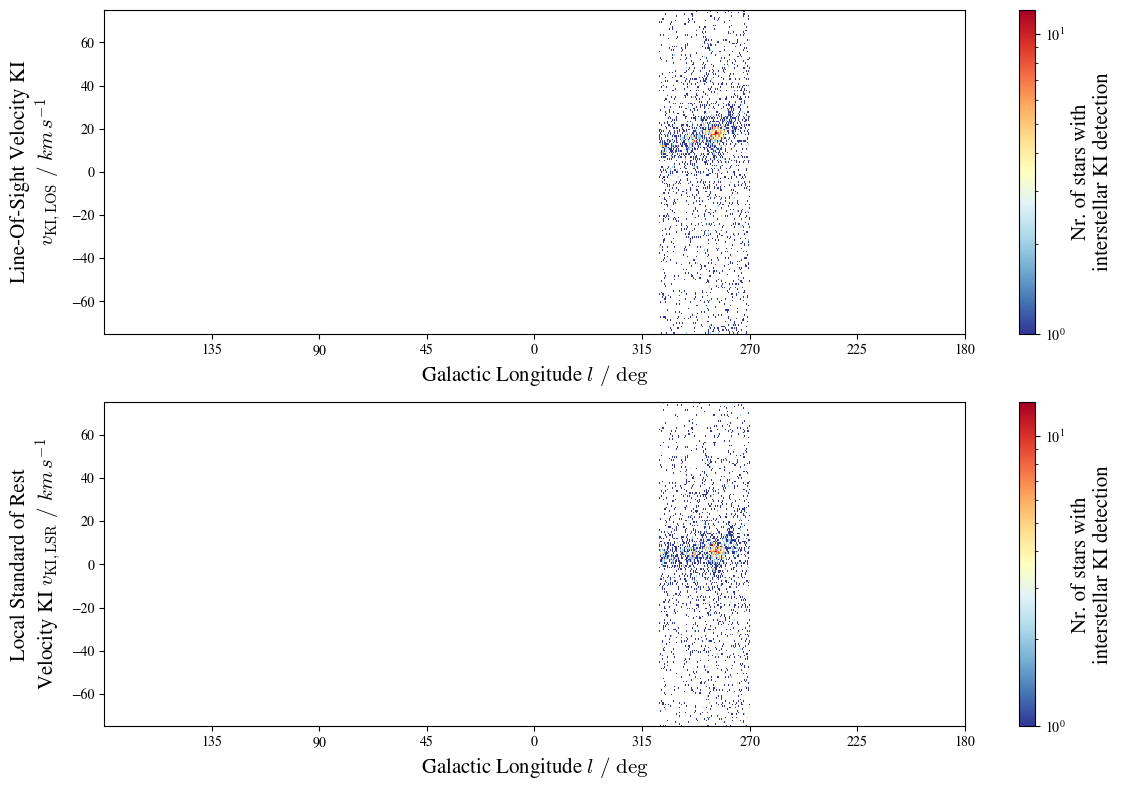

In [ ]:
# VLOS

has_k_is = np.isfinite(galah['rv_k_is_radio']) & np.isfinite(galah['l_flip'])

f, gs = plt.subplots(2,1,figsize=(12,8))

ax = gs[0]
h = ax.hist2d(
    galah['l_flip'][has_k_is],
    np.array(galah['rv_k_is_radio'][has_k_is]),
    bins = (300,np.linspace(-75,75,200)),
    cmin = 1,cmap = 'RdYlBu_r',
    norm = LogNorm()
);
cbar = plt.colorbar(h[-1],ax=ax)
cbar.set_label('Nr. of stars with\ninterstellar KI detection',fontsize=15)
ax.set_xlabel('Galactic Longitude $l~/~\mathrm{deg}$',fontsize=15)
ax.set_ylabel('Line-Of-Sight Velocity KI\n$v_\mathrm{KI,LOS}~/~{km\,s^{-1}}$',fontsize=15)
# ax.set_xlim(ax.get_xlim()[::-1])
xticks = np.arange(0, 360+180, 45)
xticks_name = xticks.copy()
xticks_name[xticks_name >= 360] -= 360
ax.set_xticks(xticks, xticks_name)
ax.set_xlim(360+180, 180)


#
ax = gs[1]

has_k_is = np.isfinite(galah['rv_k_is']) & np.isfinite(galah['l_flip'])

h = ax.hist2d(
    galah['l_flip'][has_k_is],
    np.array(galah['ki_v_lsr_radio'][has_k_is]),
    bins = (300,np.linspace(-75,75,200)),
    cmin = 1,cmap = 'RdYlBu_r',
    norm = LogNorm()
);
cbar = plt.colorbar(h[-1],ax=ax)
cbar.set_label('Nr. of stars with\ninterstellar KI detection',fontsize=15)
ax.set_xlabel('Galactic Longitude $l~/~\mathrm{deg}$',fontsize=15)
ax.set_ylabel('Local Standard of Rest\nVelocity KI $v_\mathrm{KI,LSR}~/~{km\,s^{-1}}$',fontsize=15)
# ax.set_xlim(ax.get_xlim()[::-1])
xticks = np.arange(0,360+180,45)
xticks_name = xticks.copy()
xticks_name[xticks_name >= 360] -= 360
ax.set_xticks(xticks, xticks_name)
ax.set_xlim(360+180,180)

plt.tight_layout()
# plt.savefig('figures/galah_dr4_ism_k_longitude_vs_velocity.pdf',bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
galah

<Table length=22406>
   sobject_id       tmass_id     ...    rv_k_is_radio       ki_v_lsr_radio  
                                 ...                                        
     int64          bytes17      ...       float64             float64      
--------------- ---------------- ... ------------------- -------------------
140713004601361 00000025-7541166 ...  -97.61294935987145 -104.68228016295197
140711003901371 00000344-8035334 ...   9.133985692344044   2.010897694096011
140811005001160 00000392-7323306 ...   5.839035746449281 -1.1888526831712216
140811005001171 00000440-7313079 ...  0.6246553756887887  -6.399741556691676
140711003901061 00000796-8126441 ...  10.944550535451025   3.816790619661081
140711003901030 00001085-8105228 ...  -32.50236373331469  -39.62927658692293
140711003901040 00001107-8109523 ...   9.651369271272518  2.5241038404178697
140711003901067 00001294-8134535 ... -102.63817019921706 -109.76726600518619
140713004601006 00001566-7601399 ...   12.24010844834162   5.160936164337263
            ...              ... ...                 ...                 ...
140711003901060 23593737-8124202 ...  10.362891553458642   3.240784568594827
140713004601332 23593930-7518062 ...   8.832394727963395  1.7758613278040523
150828004701015 23593935-7914094 ...   9.770853107244207  2.6625914068258956
140711003901337 23594236-8005456 ...  11.056976671381596  3.9412354549789788
140711003901032 23594728-8058587 ...      8.352540949129  1.2305414347091617
150828004701380 23594998-7856550 ... -179.89688770729438 -187.00496647437586
141104003301215 23595059-7435243 ...  15.240238735269791   8.193008875880118
140711003901037 23595079-8107438 ...  12.793161896608863   5.669813736749919
150828004701390 23595454-7906171 ...  12.502084048801416    5.39155198361179

In [ ]:
# galah.columns

In [ ]:
galah_df = pd.DataFrame(np.array(galah['sobject_id','gaiadr3_source_id','survey_name','field_id','setup','mjd','ra','dec', 'V_UVW','l','b','v_sun_projection','ki_vlsrk','l_flip','lambda_k_is','rv_k_is_radio','ki_v_lsr_radio']))
galah_df

sobject_id    gaiadr3_source_id    survey_name  field_id  \
0      140713004601361  4685221429109310080  b'galah_main'       182   
1      140711003901371  4634293351884119040  b'galah_main'       411   
2      140811005001160  4689447883087062784  b'galah_main'        76   
3      140811005001171  4689462520335582592  b'galah_main'        76   
4      140711003901061  4631183662419506048  b'galah_main'       411   
...                ...                  ...            ...       ...   
22401  140711003901032  6352336620255046912  b'galah_main'       411   
22402  150828004701380  6353031550259896064  b'galah_main'       321   
22403  141104003301215  6379489613954820864  b'galah_main'       133   
22404  140711003901037  6352328000257170048  b'galah_main'       411   
22405  150828004701390  6352936408144528384  b'galah_main'       321   

            setup           mjd          ra        dec      V_UVW           l  \
0      b'allstar'  56851.773438    0.001042 -75.687943 -37.697868  307.113381   
1      b'allstar'  56849.777344    0.014375 -80.592613 -34.638008  305.515414   
2      b'allstar'  56880.710938    0.016250 -73.391861  -3.506775  307.934743   
3      b'allstar'  56880.710938    0.018292 -73.218887 -15.143014  307.998606   
4      b'allstar'  56849.777344    0.033167 -81.445580 -55.094646  305.255114   
...           ...           ...         ...        ...        ...         ...   
22401  b'allstar'  56849.777344  359.947052 -80.983002  -7.744434  305.409765   
22402  b'allstar'  57262.667969  359.958282 -78.948608  25.830523  306.039658   
22403  b'allstar'  56965.511719  359.960754 -74.590111 -30.124155  307.515543   
22404  b'allstar'  56849.777344  359.961639 -81.128830 -54.155178  305.362962   
22405  b'allstar'  57262.667969  359.977081 -79.104752 -30.985596  305.985627   

               b  v_sun_projection    ki_vlsrk      l_flip  lambda_k_is  \
0     -41.019988         -7.069331 -104.650508  307.113381  7696.458320   
1     -36.276474         -7.123088    2.011176  305.515414  7699.198877   
2     -43.233826         -7.027888   -1.188739  307.934743  7699.114255   
3     -43.400444         -7.024397   -6.399740  307.998606  7698.980342   
4     -35.449999         -7.127760    3.817190  305.255114  7699.245377   
...          ...               ...         ...         ...          ...   
22401 -35.895384         -7.122000    1.230774  305.409765  7699.178807   
22402 -37.866417         -7.108079 -186.897080  306.039658  7694.347142   
22403 -42.075811         -7.047230    8.193784  307.515543  7699.355704   
22404 -35.754562         -7.123348    5.670360  305.362962  7699.292855   
22405 -37.716183         -7.110532    5.392073  305.985627  7699.285379   

       rv_k_is_radio  ki_v_lsr_radio  
0         -97.612949     -104.682280  
1           9.133986        2.010898  
2           5.839036       -1.188853  
3           0.624655       -6.399742  
4          10.944551        3.816791  
...              ...             ...  
22401       8.352541        1.230541  
22402    -179.896888     -187.004966  
22403      15.240239        8.193009  
22404      12.793162        5.669814  
22405      12.502084        5.391552  

[22406 rows x 17 columns]

In [ ]:
med_dist = np.array(galah['r_med'].data, dtype='float32')

field_ids = np.array(galah['field_id'].data, dtype='int16')
star_ids = np.array(galah['sobject_id'].data, dtype='int64')

ra = galah['ra'].data
dec = galah['dec'].data

ew_k_is = galah['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))
rv_k_is = galah['rv_k_is']

ebv = galah['ebv']

glon = galah['l'].data
glat = galah['b'].data

# Sources on map

In [ ]:
# Moment Maps
moment0_file = GASS_data_path / 'moment0_LMC_fg.fits'
tb_file = data_path / 'Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits'
m0, hdr = fits.getdata(tb_file, header=True)
print(m0.shape)

GASS_nhi_thin_map = 0.018224 * m0

w = WCS(hdr)
print(w)

(3500, 5100)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN' 'GLAT-TAN' 
CRVAL : 287.7000000000004 -38.69999999999963 
CRPIX : 2550.0 1750.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00666666 0.00666666 
NAXIS : 5100  3500


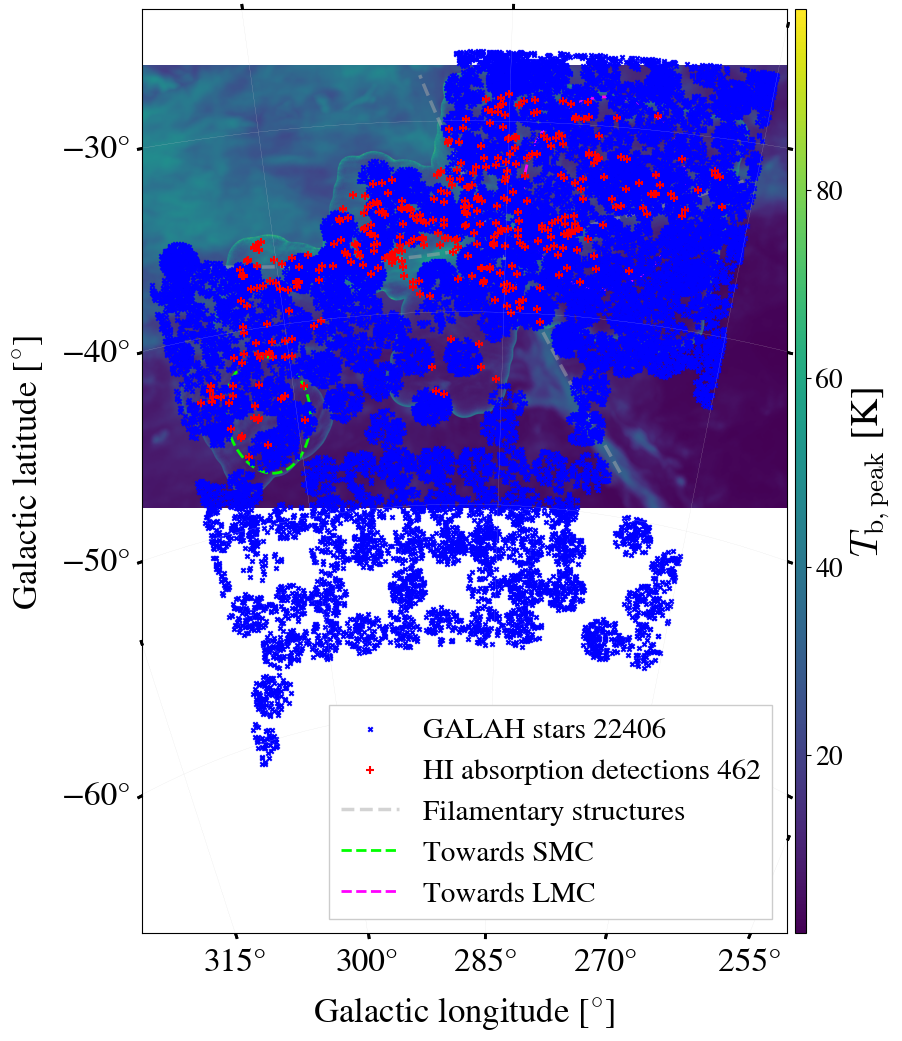

In [ ]:
# Plot
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection=WCS(hdr))

# Display the moment map image
im = ax.imshow(m0, cmap='viridis')
# ax.invert_yaxis()  # Flips the Y axis
# ax.invert_xaxis()  # Flips the X axis

ax.scatter(glon, glat,
                 s=10,
                 transform=ax.get_transform('galactic'),
                 marker='x',
                 c='b',
                 alpha=1,
                 label=f'GALAH stars {len(glon)}')
# ploti, = ax.plot([4000], [100], c='orange', marker='x', markersize=15, mew=3, ls='', lw=0, label=f'Absorption detections ({ndet})')
# ploti.set_visible(True)

# ax.scatter(src_gl, src_gb,
#                  s=40,
#                  transform=ax.get_transform('galactic'),
#                  marker='x',
#                  c='gray', # cadetblue
#                  alpha=1,
#                  label='')


ax.scatter(glon_det, glat_det, s=40, c='r', transform=ax.get_transform('galactic'),
           marker='+', # cmap=cmap, vmin=-10, vmax=10., # norm=mpl.colors.LogNorm(vmin=0.01, vmax=0.2), # vmin=0.01, vmax=0.06, # vmax=n_k_is.max(),
           label=f'HI absorption detections {len(glon_det)}')


# ploti, = ax.plot([4000], [100], c='gray', marker='x', markersize=12, mew=3, ls='', lw=0, label='Non$-$detections')
# ploti.set_visible(True)


# ax.plot(gl_boundary, gb_boundary, ls='--', c='skyblue', transform=ax.get_transform('galactic'))



# Print field_id
# for field_id, glon_mean, glat_mean in field_lb_means:
#     # print(f"Field ID: {field_id}, Mean Glon: {glon_mean:.2f}, Mean Glat: {glat_mean:.2f}")
#     # ax.scatter(glon_mean, glat_mean, s=40, transform=ax.get_transform('galactic'), marker='x', c='r', alpha=0.8, label='')
#     ax.text(glon_mean+0.5, glat_mean-0.5, str(field_id), transform=ax.get_transform('galactic'), fontsize=16, color='w')



ax.plot(ch_xcirc, ch_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.5,
        c='darkgray',
        ls='--',
        zorder=0,
        alpha=0.5,
        label='Filamentary structures'
       )


ax.plot(cv_xcirc, cv_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.5,
        c='darkgray',
        ls='--',
        zorder=0,
        alpha=0.5,
        label=''
       )


# # Approximate locations of LMC, SMC
ax.plot(SMC_xcirc,
        SMC_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.,
        zorder=0,
        color='lime',
        ls='--',
        label='Towards SMC'
       )
ax.plot(LMC_xcirc,
        LMC_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.,
        zorder=0,
        color='fuchsia',
        ls='--',
        label='Towards LMC'
       )



# Title
# ax.set_title(f"LMC: {nfields} fields, {nsrcs} sources", fontsize=18)

# Add axes labels
ax.set_xlabel("Galactic Longitude [degrees]", fontsize=16)
ax.set_ylabel("Galactic Latitude [degrees]", fontsize=16)

## Color bar
# cbar = fig.colorbar(sct, ax=ax, orientation='vertical', fraction=0.02, pad=0.006, aspect=35)
# cbar.ax.set_ylabel('Optical Depth Noise [%]', rotation=90, labelpad=5., fontsize=15)
# cbar.ax.tick_params(labelsize=14)



# ax.set_xlim(lmc_glon[1], lmc_glon[0])
# ax.set_ylim(lmc_glat[0], lmc_glat[1])

# ax.set_xlim(0, 5000)
# ax.set_ylim(500, 4200)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', location='right', fraction=0.008, pad=0.005, aspect=85)
cbar.ax.set_ylabel('$T_\mathrm{b,peak}$ [K]', rotation=90, labelpad=5., fontsize=28)
cbar.ax.tick_params(labelsize=20)


# Title
# ax.set_title(f"LMC: {n_fields} fields, {n_sources} sources", fontsize=18)

# Add axes labels
ax.set_xlabel(r'Galactic longitude [$^{\circ}$]', fontsize=25)
ax.set_ylabel(r'Galactic latitude [$^{\circ}$]', fontsize=25)

ax.tick_params(axis='x', labelsize=24, pad=4)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)




# Overlay set of RA/Dec Axes
# overlay = ax.get_coords_overlay('galactic')
# overlay.grid(color='white', ls='dotted', lw=0.3)
# overlay[0].set_axislabel('Galactic Longitude [deg]', fontsize=16)
# overlay[1].set_axislabel('Galactic Latitude [deg]', fontsize=16)

ax.legend(loc='lower right', fancybox=False, framealpha=1., labelcolor='k', facecolor='w', fontsize=21)
ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)
plt.show()

# Select a HI absorption detection

In [ ]:
df_det.shape

(462, 45)

In [ ]:
hi_det_src_id = 4
# hi_det_src_id = 279

if False:
    # Example catalogs with glon and glat
    # catalog1 = np.array([[10, 20], [15, 25], [30, 45]])  # (glon, glat) for catalog 1
    # catalog2 = np.array([[glon_star, glat_star]])  # (glon, glat) for catalog 2

    # Convert catalogs to SkyCoord objects
    coords1 = SkyCoord(l=glon*u.deg, b=glat*u.deg, frame='galactic') # GALAH stars
    coords2 = SkyCoord(l=[glon_det[hi_det_src_id]]*u.deg, b=[glat_det[hi_det_src_id]]*u.deg, frame='galactic') # 1 HI obsorption detection

    # Calculate separations and find the closest pair
    idx, sep2d, _ = coords1.match_to_catalog_sky(coords2)

    # Find the closest pair
    closest_pair_idx = np.argmin(sep2d)
    closest_sep = sep2d[closest_pair_idx].deg
    closest_coords1_glon = glon[closest_pair_idx]
    closest_coords1_glat = glat[closest_pair_idx]
    # closest_coords2 = catalog2[idx[closest_pair_idx]]

    # Print results
    print(f"Closest pair:")
    print(f"Star coordinate ID: {closest_pair_idx}")
    print(f"Star coordinates: {closest_coords1_glon, closest_coords1_glat}")


    print(f"HI detection coordinate ID: {idx[closest_pair_idx]}")
    print(f"HI detection coordinates: {glon_det[hi_det_src_id], glat_det[hi_det_src_id]}")
    # print(f"Angular separation: {closest_sep:.4f}")
    print(closest_sep, 'deg')

In [ ]:
def get_angular_distance(glon_src, glat_src, star_glon, star_glat):
    """
    Find stars within a specified angular radius of a source position in Galactic coordinates.

    Parameters:
    -----------
    glon_src : float
        Galactic longitude of the source in degrees
    glat_src : float
        Galactic latitude of the source in degrees
    stars_glon : array-like
        Galactic longitudes of stars in degrees
    stars_glat : array-like
        Galactic latitudes of stars in degrees
    star_ids : array-like
        Identifiers for each star

    Returns:
    --------
    nearby_ids : numpy array
        IDs of stars within the search radius
    nearby_coords : dict
        Dictionary containing coordinates and distances of nearby stars:
        - 'glon': Galactic longitudes
        - 'glat': Galactic latitudes
        - 'distances': Angular distances in degrees
    """

    # Convert everything to radians for spherical trig calculations
    glon_src_rad = np.radians(glon_src)
    glat_src_rad = np.radians(glat_src)
    star_glon_rad = np.radians(star_glon)
    star_glat_rad = np.radians(star_glat)

    # Use the spherical law of cosines to find angular distances
    # cos(c) = sin(lat1)sin(lat2) + cos(lat1)cos(lat2)cos(lon1-lon2)
    angular_distance_rad = np.arccos(
        np.sin(glat_src_rad) * np.sin(star_glat_rad) +
        np.cos(glat_src_rad) * np.cos(star_glat_rad) *
        np.cos(glon_src_rad - star_glon_rad)
    )

    # Convert distances back to degrees
    angular_distance = np.degrees(angular_distance_rad)

    return angular_distance

In [ ]:
def find_nearby_stars(glon_src, glat_src, stars_glon, stars_glat, star_ids, radius_deg):
    """
    Find stars within a specified angular radius of a source position in Galactic coordinates.

    Parameters:
    -----------
    glon_src : float
        Galactic longitude of the source in degrees
    glat_src : float
        Galactic latitude of the source in degrees
    stars_glon : array-like
        Galactic longitudes of stars in degrees
    stars_glat : array-like
        Galactic latitudes of stars in degrees
    star_ids : array-like
        Identifiers for each star
    radius_deg : float
        Search radius in degrees

    Returns:
    --------
    nearby_ids : numpy array
        IDs of stars within the search radius
    nearby_coords : dict
        Dictionary containing coordinates and distances of nearby stars:
        - 'glon': Galactic longitudes
        - 'glat': Galactic latitudes
        - 'distances': Angular distances in degrees
    """

    # Convert everything to radians for spherical trig calculations
    glon_src_rad = np.radians(glon_src)
    glat_src_rad = np.radians(glat_src)
    stars_glon_rad = np.radians(stars_glon)
    stars_glat_rad = np.radians(stars_glat)
    radius_rad = np.radians(radius_deg)

    # Use the spherical law of cosines to find angular distances
    # cos(c) = sin(lat1)sin(lat2) + cos(lat1)cos(lat2)cos(lon1-lon2)
    angular_distances_rad = np.arccos(
        np.sin(glat_src_rad) * np.sin(stars_glat_rad) +
        np.cos(glat_src_rad) * np.cos(stars_glat_rad) *
        np.cos(glon_src_rad - stars_glon_rad)
    )

    # Convert distances back to degrees
    angular_distances = np.degrees(angular_distances_rad)

    # Create boolean mask for stars within radius
    mask = (angular_distances < radius_deg)

    # Collect results for nearby stars
    nearby_coords = {
        'glon': stars_glon[mask],
        'glat': stars_glat[mask],
        'distances': angular_distances[mask],
        'ki_ew_ism': galah['ew_k_is'][mask]
    }

    nearby_ids = star_ids[mask]

    return nearby_ids, nearby_coords

In [ ]:
# Example usage:
# glon_src = 30.0  # Source galactic longitude
# glat_src = -0.5  # Source galactic latitude
radius = 0.28     # Search radius in degrees


# Assuming star_ids is a numpy array with star identifiers
nearby_ids, nearby_coords = find_nearby_stars(glon_det[hi_det_src_id],
                                              glat_det[hi_det_src_id],
                                              glon,
                                              glat,
                                              star_ids,
                                              radius
                                              )

# Access the results
print(f'Found {len(nearby_ids)} nearby stars')
print('Star IDs:', nearby_ids)
print('Galactic longitudes:', nearby_coords['glon'])
print('Galactic latitudes:', nearby_coords['glat'])
print('Angular distances (degrees):', nearby_coords['distances'])


# Print results
print(f'HI detection coordinates: {glon_det[hi_det_src_id], glat_det[0]}')
# print(f"Angular separation: {closest_sep:.4f}")
print(nearby_coords['distances'], 'deg')


print(f'nearby_stars_glon: {nearby_coords["glon"]}')
print(f'nearby_stars_glat: {nearby_coords["glat"]}')
# print(f"Angular separation: {closest_sep:.4f}")
print(f'nearby_distances: {nearby_coords["distances"]} deg')

Found 5 nearby stars
Star IDs: [161116002201185 161116002201176 161116002201172 161116002201156
 161116002201146]
Galactic longitudes: [305.71817627 305.64587647 305.42819335 305.334998   305.22369706]
Galactic latitudes: [-43.28102411 -43.17658643 -43.18601828 -43.02393563 -42.94928509]
Angular distances (degrees): [0.24682319 0.12985187 0.1604002  0.17241305 0.27366352]
HI detection coordinates: (np.float64(305.5654628031906), np.float64(-43.21804746655667))
[0.24682319 0.12985187 0.1604002  0.17241305 0.27366352] deg
nearby_stars_glon: [305.71817627 305.64587647 305.42819335 305.334998   305.22369706]
nearby_stars_glat: [-43.28102411 -43.17658643 -43.18601828 -43.02393563 -42.94928509]
nearby_distances: [0.24682319 0.12985187 0.1604002  0.17241305 0.27366352] deg


In [ ]:
mask = np.isin(galah['sobject_id'], nearby_ids)
selected_close_stars = galah[mask]
selected_close_stars

<Table length=5>
   sobject_id       tmass_id     ...    rv_k_is_radio       ki_v_lsr_radio  
                                 ...                                        
     int64          bytes17      ...       float64             float64      
--------------- ---------------- ... ------------------- -------------------
161116002201185 00222883-7341246 ... -190.96672148770446  -198.4541939212128
161116002201176 00225981-7348051 ... -133.53760505388246  -141.0346316948744
161116002201172 00251616-7348546 ... -134.64279531329555 -142.18503010103782
161116002201156 00255525-7359061 ...   12.59575372727747   5.042462102500794
161116002201146 00265702-7404112 ...  -93.65560704488097 -101.22809218245864

# Stellar spectra in the field

In [ ]:
gaskap_src = df_det.iloc[hi_det_src_id]

gaskap_src_name = gaskap_src.comp_name
gaskap_field = gaskap_src.sbid
print('GASKAP field: ', gaskap_field)

GASKAP field:  30665


In [ ]:
def gaussianfcn(x, A, mu, fwhm):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def blended_gaussian(x, hgts, cens, widths):
    result = np.zeros_like(x, dtype=float)
    for ai, xi, wi in zip(hgts, cens, widths):
        result += gaussianfcn(x, ai, xi, wi)
    return result

def check_within_component_widths(x0, hgts, cens, widths):
    min_x = float('inf')
    max_x = float('-inf')

    for ai, xi, wi in zip(hgts, cens, widths):
        sigma = wi / (2. * np.sqrt(2. * np.log(2.)))
        component_min = xi - 2.5 * sigma # or 2*sigma
        component_max = xi + 2.5 * sigma # or 2*sigma

        min_x = min(min_x, component_min)
        max_x = max(max_x, component_max)

    return min_x <= x0 <= max_x, min_x, max_x



# Check if HI vlsr within KI velocity range
def check_within_ki_widths(x0, x0_ki, ki_sigma = 5.5):
    min_x = x0_ki - 2.5*ki_sigma
    max_x = x0_ki + 2.5*ki_sigma
    return min_x <= x0 <= max_x, min_x, max_x




# Example usage:
amp = [1., 1., 2.]
xcen = [0.8, 3.0, 1.5]
width = [0.5, 5.0, 3.0]
x0 = 2.5

xoinyn, x_min, xmax = check_within_component_widths(x0, amp, xcen, width)

if xoinyn:
    print(f"x0 = {x0} is within the blended linewidth (component widths).")
else:
    print(f"x0 = {x0} is outside the blended linewidth (component widths).")

x0 = 2.5 is within the blended linewidth (component widths).


In [ ]:
xaxis = np.linspace(-20, 20, 100)

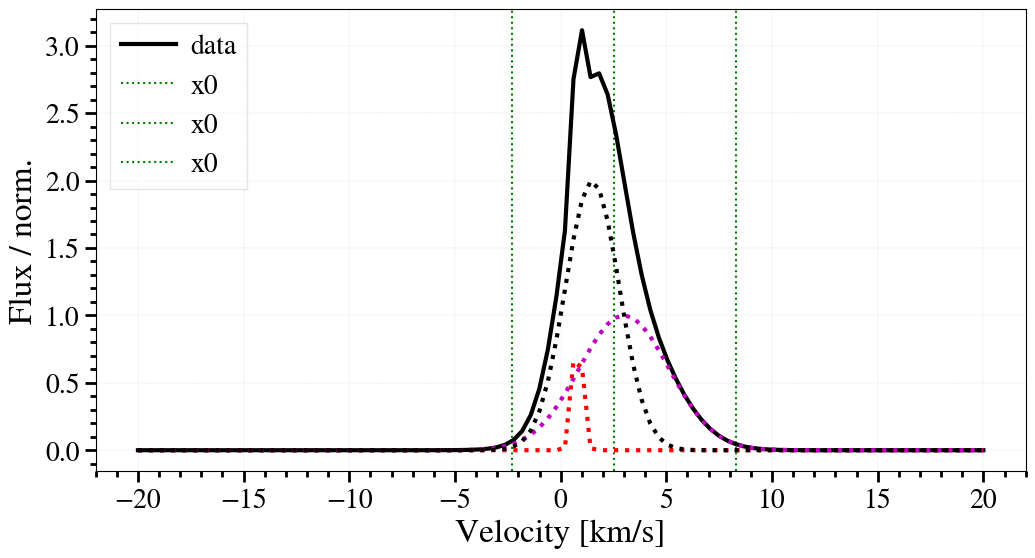

In [ ]:
# Plot
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

ax.plot(xaxis, blended_gaussian(xaxis, amp, xcen, width), 'k-', lw=3., label='data')
ax.plot(xaxis, gaussianfcn(xaxis, amp[0], xcen[0], width[0]), 'r:', lw=3., label='')
ax.plot(xaxis, gaussianfcn(xaxis, amp[1], xcen[1], width[1]), 'm:', lw=3., label='')
ax.plot(xaxis, gaussianfcn(xaxis, amp[2], xcen[2], width[2]), 'k:', lw=3., label='')

ax.axvline(x=x0, color='green', ls=':', zorder=-2, label='x0')
ax.axvline(x=x_min, color='green', ls=':', zorder=-2, label='x0')
ax.axvline(x=xmax, color='green', ls=':', zorder=-2, label='x0')

ax.set_xlabel(r'Velocity [km/s]', fontsize=24)
ax.set_ylabel(r'Flux / norm.', fontsize=24)


# Add axes labels
ax.minorticks_on()
ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)

# ax.set_xlim(-80, 80.)

# ax.set_ylim(, 80.)


ax.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)
leg = ax.legend(loc='upper left', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=20, handletextpad=0.5) # handletextpad=-2.0
# [item.set_visible(False) for item in leg.legend_handles]

# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.2,
                    hspace=0.3
                    )

# Save: spectra_eg.png
# plt.tight_layout()
plt.show()
plt.close()

# For all HI absoprtion detections

In [ ]:
# lambda_rest = 7698.9643 # Angstroms for KI
radius = 0.16 # Search radius in degrees (here R = 0.75 pc)

# Initialize empty DataFrame with named columns
columns = ['src_id', 'src_name', 'src_glon', 'src_glat', 'nhi', 'sig_nhi', 'nhi_thin', 'star_id', 'sep_distance', 'r_med',
           'ew_ki_ism', 'ew_ki_ism_err', 'amp_ki_ism', 'res_max_ki_ism', 'ki_ism_vlsr_obs', 'ki_ism_avg_vlsr_obs','ki_ism_sig_vlsr_obs',
           'emt_min_vlsr', 'vlsr_hi_ki_diff', 'vlsr_diff_min', 'n_nearby_stars']
ggdf = pd.DataFrame(columns=columns)

In [ ]:
# KI absorption flux 3-sigma threshold
nsigma = 2.9

# The separation threshold between velocities of CNM component and KI absorption feature
vlsr_hi_ki_diff_limit = 11. # km/s

In [ ]:
# Loop through 462 HI absorption detection
for hi_det_src_id in range(462):
    print('==============================================')

    # GASKAP source
    gaskap_src = df_det.iloc[hi_det_src_id]

    gaskap_src_name = gaskap_src.comp_name
    gaskap_field = gaskap_src.sbid

    nhi = gaskap_src.nhi
    sig_nhi = gaskap_src.signhi
    nhi_thin = gaskap_src.nhi_thin

    src_glon = gaskap_src.glon
    src_glat = gaskap_src.glat
    print('src_glon, src_glat: ', hi_det_src_id, src_glon, src_glat)


    # HI data: Open and load the pickle file
    gaskap_src_file = gaskap_hires_result_path / ('sb'+str(gaskap_field)) / f'{gaskap_src_name}.pkl'


    with open(gaskap_src_file, 'rb') as f:  # "rb" mode means read in binary
        gaskap_res_data = pickle.load(f)


    gaskap_em_closest_em_profile = gaskap_res_data['EM_profiles'][:, 0]
    gaskap_em_avg_em_profile = np.mean(gaskap_res_data['EM_profiles'], axis=1)

    vlsr_gaskap = gaskap_res_data['vlsr_gaskap']
    sigemt_gaskap = gaskap_res_data['sigemt']
    emt_gaskap = gaskap_res_data['emt']

    ncnm = gaskap_res_data['ncnm']
    hgtcnm = gaskap_res_data['hgtcnm']
    cencnm = gaskap_res_data['cencnm']
    widcnm = gaskap_res_data['widcnm']

    # compute sum of gaussians
    hi_tau_arr = np.zeros_like(vlsr_gaskap)
    for i in range(ncnm):
        hi_tau_arr += gaussian(vlsr_gaskap, hgtcnm[i], cencnm[i], widcnm[i])


    # Assuming star_ids is a numpy array with star identifiers
    nearby_ids, nearby_coords = find_nearby_stars(glon_det[hi_det_src_id],
                                                  glat_det[hi_det_src_id],
                                                  glon,
                                                  glat,
                                                  star_ids,
                                                  radius
                                                  )
    n_nearby_stars = len(nearby_ids)
    print(f'GASKAP src {gaskap_src_name}: Found {n_nearby_stars} nearby stars')

    mask = np.isin(galah['sobject_id'], nearby_ids)
    selected_close_stars = galah[mask]


    # Find the associated KI absorption from nearby stars
    vlsr_diff_min = 999.
    ki_amp_max    = -999.
    ki_ew_max     = -999.
    k_min         = 0
    emt_min_vlsr  = -999.

    star_id_selected   = -999
    sep_distance_selected = -999.
    ew_ki_ism_selected = -999.
    ew_ki_ism_err_selected = -999.
    ki_amp_selected    = -999.

    ki_nu_max_res_selected   = -999.
    ki_max_res_selected      = -999.
    ki_ism_vlsr_obs_selected = -999.

    emt_min_vlsr_selected    = -999.
    vlsr_hi_ki_diff_selected = -999.
    star_r_med_selected      = -999.


    ki_amp_stars      = []
    ki_max_res_stars  = []
    ki_dist_stars     = []
    ki_ang_dist_stars = []

    # For uncertainties/errorbars
    gaskap_star_ids = []
    star_med_dists = []
    ki_ism_ews     = []

    ki_ism_obs_vlsrs = []
    emt_min_vlsrs    = []
    vlsr_hi_ki_diffs = []

    for k, (star_id, closest_coords_glon, closest_coords_glat, sep_distance) in enumerate(zip(nearby_ids, nearby_coords['glon'], nearby_coords['glat'], nearby_coords['distances'])):

        closest_star_info = galah[galah['sobject_id'] == star_id]

        field_id = closest_star_info['field_id'].data[0]
        path = data_path / 'galah' / f'field_{field_id}'
        make_dir(path)

        sobject_id_str = str(star_id)
        output_star_id_file = path / f'{sobject_id_str}_allstar_fit_spectrum.fits'

        download_galah_data(path, star_id)

        # stellar data: wavelength, flux, model
        tmp_spec_table = Table.read(output_star_id_file)

        wavelength = tmp_spec_table['wave']
        flux = tmp_spec_table['sob']
        flux_mod = tmp_spec_table['smod']

        # for KI
        waverange_idx = np.where((wavelength > 7695.) & (wavelength < 7704.5))[0]
        ki_wavelength = np.array(wavelength[waverange_idx])
        ki_flux = np.array(flux[waverange_idx])
        ki_flux_mod = np.array(flux_mod[waverange_idx])

        star_glon = closest_star_info['l'].data[0]
        star_glat = closest_star_info['b'].data[0]

        star_rv_comp_1 = closest_star_info['rv_comp_1'].data[0] # km/s

        # Residuels: |model - data|
        res = np.abs(ki_flux_mod - ki_flux)
        max_res_id = np.argmax(res)
        ki_nu_max_res = ki_wavelength[max_res_id]


        # VSLRK of the max KI residual
        ki_ism_vlsr_obs = wavelength_to_vlsrk_with_galah_correction(ki_nu_max_res, lambda_rest, star_glon, star_glat, star_rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25)

        # the width of Ki absorption feature (in Angstrom)
        sigma_k_ism_star_val = closest_star_info['sigma_k_is'].data[0]
        sigma_k_ism_star_val_err = 0.1*sigma_k_ism_star_val
        vel_sigma_k_ism_val  = c*sigma_k_ism_star_val / lambda_rest
        vel_fwhm_k_ism_val   = 2 * np.sqrt(2 * np.log(2)) * vel_sigma_k_ism_val

        # the Equivalent width of Ki absorption feature (in Angstrom)
        ki_ew_ism_star_val = closest_star_info['ew_k_is'].data[0]

        # EW = sqrt(2pi) * A * sigma
        # the Amplitude of Ki absorption feature (flux vs Angstrom)
        ki_amp = ki_ew_ism_star_val / sigma_k_ism_star_val / np.sqrt(2.*np.pi) # See Sven's email "KI line depth from EW and width"
        ki_amp_err = 0.1 * ki_amp

        # Uncertainties in EW_KI
        ki_ew_ism_star_val_err = np.sqrt(2.*np.pi) * np.sqrt((sigma_k_ism_star_val*ki_amp_err)**2 + (ki_amp*sigma_k_ism_star_val_err)**2)

        # To VLSRK
        ki_xvlsr = wavelength_to_vlsrk_with_galah_correction(ki_wavelength, lambda_rest, star_glon, star_glat, star_rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25)


        ki_ew_ism_star = str(np.round(ki_ew_ism_star_val, 3))
        glon_star = np.round(closest_star_info['l'].data[0], 3)
        glat_star = np.round(closest_star_info['b'].data[0], 3)

        # distance to star
        star_med_dist = closest_star_info['r_med'].data[0] # pc

        # Given values
        # Convert angular separation to radians
        angular_sep_rad = np.radians(sep_distance)

        # Compute linear separation
        linear_sep_pc = med_dist * angular_sep_rad

        min_emt_id = np.argmin(emt_gaskap)
        emt_min_vlsr = vlsr_gaskap[min_emt_id]


        # Plot spectra
        res = np.abs(ki_flux_mod - ki_flux)
        res_std = np.std( np.concatenate((res[:5], res[-5:])) )
        max_res_id = np.argmax(res)
        max_res_val = res[max_res_id]
        xvlsr_max_res = closest_star_info['ki_v_lsr_radio'].data[0]


        # Check KI_VLSR is in HI absorption range?
        ki_vlsr_inyn, vlsr_left, vlsr_right = check_within_component_widths(xvlsr_max_res, hgtcnm, cencnm, widcnm)

        # Check HI_VLSR is in KI absorption range?
        hi_vlsr_inyn, ki_vlsr_left, ki_vlsr_right = check_within_ki_widths(xvlsr_max_res, emt_min_vlsr, ki_sigma = 5.5)


        min_ki_mod_id = np.argmin(ki_flux_mod)
        ki_xvlsr_min_mod = ki_xvlsr[min_ki_mod_id]

        cencnm_idx = np.argmin(np.abs(cencnm - xvlsr_max_res))
        emt_min_vlsr = cencnm[cencnm_idx]
        vlsr_hi_ki_diff = np.abs(xvlsr_max_res - emt_min_vlsr) # compare HI absorption line with KI absorption velocity (using closest HI absorption line)


        vlsr_hi_ki_diff_cond = (vlsr_hi_ki_diff < vlsr_hi_ki_diff_limit)
        ki_ew_ism_star_cond = (ki_ew_ism_star_val > 0.004)
        star_med_dist_cond = (star_med_dist > 280.)
        ki_ism_vlsr_obs_cond = (np.abs(ki_ism_vlsr_obs) < 30.)
        ki_max_res_cond = (max_res_val > nsigma*res_std)
        ki_ism_stellar_mod_vlsr_cond = (np.abs(ki_xvlsr_min_mod - emt_min_vlsr) > 11.) if (ki_flux_mod[min_ki_mod_id] < 0.8) else True

        print('vlsr_hi_ki_diff_cond', vlsr_hi_ki_diff_cond)
        print('ki_ew_ism_star_cond', ki_ew_ism_star_cond)
        print('star_med_dist_cond', star_med_dist_cond)
        print('ki_ism_vlsr_obs_cond', ki_ism_vlsr_obs_cond)
        print('ki_max_res_cond', ki_max_res_cond)
        print('ki_vlsr_inyn', (ki_vlsr_inyn) )
        print('hi_vlsr_inyn', (hi_vlsr_inyn) )
        print('ki_ism_stellar_mod_vlsr_cond (np.abs(ki_xvlsr_min_mod - emt_min_vlsr) > 11.)', (ki_ism_stellar_mod_vlsr_cond) )

        ki_vlsr_inyn = (ki_vlsr_inyn or hi_vlsr_inyn)

        all_conds = (ki_ew_ism_star_cond and
                     vlsr_hi_ki_diff_cond and
                     star_med_dist_cond and
                     ki_max_res_cond and
                     ki_ism_stellar_mod_vlsr_cond and
                     ki_vlsr_inyn
                    )



        if True:
            # Grid plot
            mpl.rcParams['axes.linewidth'] = 1.5

            fig = plt.figure(figsize=(14,11))
            gs = gridspec.GridSpec(10, 10)
            ax = plt.subplot(gs[0:5, 0:10])
            ax_cdf = plt.subplot(gs[5:, 0:10],sharex=ax)

            xylabel = 30
            xytlabel = 28

            ## ax
            ax.step(vlsr_gaskap[::4], 0.05*gaskap_em_closest_em_profile[::4], color='gray', ls='-', zorder=-2, lw=2.5, label='HI emission')

            ax.step(vlsr_gaskap[::4], -np.log(emt_gaskap[::4]), color='dodgerblue', ls='-', lw=3, zorder=0, label='HI absorption')
            ax.plot(vlsr_gaskap, hi_tau_arr, 'k--', zorder=0, lw=2, label='HI absorption fit')

            ax.axvline(x=cencnm[0], color='k', ls=':', zorder=1, lw=2, label='CNM component')


            ax.set_ylabel('Arbitrary flux units', fontsize=xylabel-2)

            ax.minorticks_on()
            ax.tick_params(axis='x', labelsize=xytlabel, pad=4)
            ax.tick_params(axis='y', labelsize=xytlabel)
            ax.tick_params(which='both', width=2)
            ax.tick_params(which='major', length=6)
            ax.tick_params(which='minor', length=3)


            ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
            ax.legend(loc='upper right', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=22)

            plt.setp(ax.get_xticklabels(), visible=False)

            ax.set_xlim(-60, 60.)
            ax.set_xlim(-0.25, 4.)



            # KI ax
            ki_lines = []
            ki_l1, = ax_cdf.step(ki_xvlsr, ki_flux, 'b-', lw=3, label='KI absorption')
            ki_lines.append(ki_l1)
            ki_l1, = ax_cdf.step(ki_xvlsr, ki_flux_mod, 'r--', lw=3, label='Stellar model')
            ki_lines.append(ki_l1)

            ki_lines2 = []
            ki_l1, = ax_cdf.step(ki_xvlsr, 1.1 + res, 'b--', lw=3, label=r'KI residuals') # | model - data |
            ki_lines2.append(ki_l1)

            gaussian_curve = gaussian(velocity_range, ki_amp, xvlsr_max_res, vel_fwhm_k_ism_val)
            ki_l1, = ax_cdf.plot(velocity_range, 1.1 + gaussian_curve, 'm--', zorder=1, lw=3, label='Gaussian fit')
            ki_lines2.append(ki_l1)

            ki_l1 = ax_cdf.axvline(x=xvlsr_max_res, color='b', ls=':', zorder=1, lw=2, label='ki_ism_vlsr (gauss)')
            ki_lines2.append(ki_l1)

            ki_l1 = ax_cdf.axhline(y = 2.7*res_std + 1.1, color = 'b', linestyle = ':', label='3sigma threshold')
            ki_lines2.append(ki_l1)



            # xyticks
            ax_cdf.minorticks_on()
            ax_cdf.tick_params(axis='x', labelsize=xytlabel, pad=4)
            ax_cdf.tick_params(axis='y', labelsize=xytlabel)
            ax_cdf.tick_params(which='both', width=2)
            ax_cdf.tick_params(which='major', length=8)
            ax_cdf.tick_params(which='minor', length=4)

            ax_cdf.set_ylim(0.5,1.4)
            ax_cdf.set_xlim(-60, 60.)

            ax_cdf.set_xlabel(r'Velocity [km s]', fontsize=xylabel)
            ax_cdf.set_ylabel('Arbitrary flux units', fontsize=xylabel-2)

            ax_cdf.tick_params('y', colors='k')
            ax_cdf.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

            first_legend = ax_cdf.legend(handles=ki_lines, loc='upper right', fancybox=False, framealpha=0.8, labelcolor='k', fontsize=24.)
            ax_cdf.add_artist(first_legend)

            ax_cdf.legend(handles=ki_lines2, loc='lower left', fancybox=False, framealpha=0.8, labelcolor='k', fontsize=24.)

            selected_yn = '*' if (all_conds and (ki_amp > ki_amp_max) and (ki_ew_ism_star_val > ki_ew_max) ) else ''
            ki_in_yn = '[Y]' if (all_conds and ki_vlsr_inyn) else '[No]'
            ax.set_title(f'[{gaskap_src_name}, {k+1}/{n_nearby_stars}] {selected_yn}{ki_in_yn}: {sobject_id_str}, \n KI EW = {ki_ew_ism_star}, ' + \
                         'l,b=(%5.2f, %5.2f), ' % (glon_star, glat_star) + \
                         'star rv=%5.2f, star dist=%5.2f}' % (star_rv_comp_1, star_med_dist),
                         fontsize=24)
            print(f'[{gaskap_src_name}, {k+1}/{n_nearby_stars}] {selected_yn}{ki_in_yn}: {sobject_id_str}, KI EW = {ki_ew_ism_star}, KI amp = {ki_amp}, ' + \
                         'l,b=(%5.2f, %5.2f), ' % (glon_star, glat_star) + \
                         'star rv=%5.2f, star dist=%5.2f}' % (star_rv_comp_1, star_med_dist))

            # Add axes labels
            ax.minorticks_on()
            ax.tick_params(axis='x', labelsize=20, pad=4)
            ax.tick_params(axis='y', labelsize=20)
            ax.tick_params(which='both', width=2)
            ax.tick_params(which='major', length=8)
            ax.tick_params(which='minor', length=4)

            ax.set_xlim(-60, 60.)

            ymin_flux = np.min(np.min(flux_mod))
            ymax_flux = np.max(flux)


            ax.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)
            leg = ax.legend(loc='upper left', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=20, handletextpad=0.5)

            # set the spacing between subplots
            plt.subplots_adjust(left=None,
                                bottom=None,
                                right=None,
                                top=None,
                                wspace=0.,
                                hspace=0.
                                )

            # Save: spectra_eg.png
            # plt.tight_layout()
            plt.show()
            plt.close()
        # End - if: plot

        if not all_conds:
            continue

        if ( (vlsr_hi_ki_diff < vlsr_diff_min) and (ki_amp > ki_amp_max) and (ki_ew_ism_star_val > ki_ew_max)):
            vlsr_diff_min = vlsr_hi_ki_diff
            ki_amp_max = ki_amp
            ki_ew_max = ki_ew_ism_star_val
            k_min = k

            star_id_selected         = star_id
            sep_distance_selected    = sep_distance
            star_r_med_selected      = star_med_dist
            ew_ki_ism_selected       = ki_ew_ism_star_val
            ew_ki_ism_err_selected   = ki_ew_ism_star_val_err
            ki_ism_vlsr_obs_selected = xvlsr_max_res
            emt_min_vlsr_selected    = emt_min_vlsr
            vlsr_hi_ki_diff_selected = vlsr_hi_ki_diff
            ki_amp_selected          = ki_amp
            ki_max_res_selected      = max_res_val
        # End - if: select a star along GASKAP line of sight

        # For errorbars
        gaskap_star_ids.append(star_id)
        star_med_dists.append(star_med_dist)

        ki_ism_ews.append(ki_ew_ism_star_val)
        ki_ism_obs_vlsrs.append(xvlsr_max_res) # ki_ism_vlsr
        emt_min_vlsrs.append(emt_min_vlsr)
        vlsr_hi_ki_diffs.append(vlsr_hi_ki_diff)

        if ki_amp > 2.7*res_std:
            ki_amp_stars.append(ki_amp)
            ki_max_res_stars.append(max_res_val)
            ki_dist_stars.append(star_med_dist)
            ki_ang_dist_stars.append(sep_distance)
        # End - if: criteria on the 3sigma threshold for nearby stars
    # End - for: nearby stars


    n_nearby_stars = len(gaskap_star_ids)
    ki_ism_sig_vlsr_obs_val = 5. if (n_nearby_stars == 0) else 5. / np.sqrt(n_nearby_stars)
    ki_ism_avg_vlsr_obs_val = -999. if (len(ki_ism_obs_vlsrs) == 0) else np.mean(np.array(ki_ism_obs_vlsrs))

    new_row = {'src_id': hi_det_src_id,
                'src_name': gaskap_src_name,
                'src_glon': src_glon,
                'src_glat': src_glat,
                'nhi': nhi,
                'sig_nhi': sig_nhi,
                'nhi_thin': nhi_thin,
                'star_id': star_id_selected,
                'sep_distance': sep_distance_selected, # in degrees
                'r_med': star_r_med_selected,
                'ew_ki_ism': ew_ki_ism_selected,
                'ew_ki_ism_err': ew_ki_ism_err_selected,
                'amp_ki_ism': ki_amp_selected,
                'res_max_ki_ism': ki_max_res_selected,
                'ki_ism_vlsr_obs': ki_ism_vlsr_obs_selected,
                'ki_ism_avg_vlsr_obs': ki_ism_avg_vlsr_obs_val,
                'ki_ism_sig_vlsr_obs': ki_ism_sig_vlsr_obs_val,
                'emt_min_vlsr': emt_min_vlsr_selected,
                'vlsr_hi_ki_diff': vlsr_hi_ki_diff_selected,
                'vlsr_diff_min': vlsr_diff_min,
                'n_nearby_stars': n_nearby_stars,
                }
    ggdf.loc[len(ggdf)] = new_row


    print('hisrc_id, gaskap_field, gaskap_src_name, k_min and vlsr_diff_min, r_med: ', hi_det_src_id, hi_det_src_id, gaskap_field, gaskap_src_name, k_min, vlsr_diff_min, star_r_med_selected)
    print(ki_ism_vlsr_obs_selected)
    print()
# End - for: GASKAP abs sources

In [ ]:
current_ggdf = ggdf[ggdf['star_id'] > 0]

In [ ]:
# Number of matched stars (out of 462 HI absorption lines of sight)
print(100.*current_ggdf.shape[0]/ggdf.shape[0])

62.77056277056277


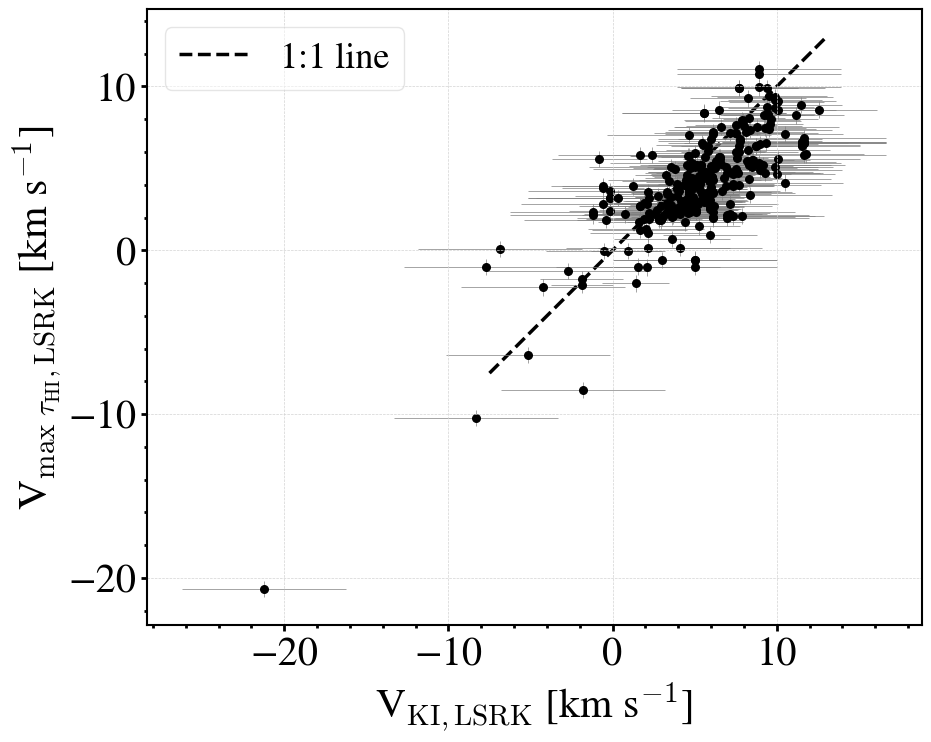

In [ ]:
ki_ism_vlsr_obs_selected = current_ggdf['ki_ism_vlsr_obs']
ki_ism_avg_vlsr_obs = current_ggdf['ki_ism_avg_vlsr_obs']
emt_min_vlsrs = current_ggdf['emt_min_vlsr']
ki_ism_sig_vlsr_obs = current_ggdf['ki_ism_sig_vlsr_obs']


# Plot
fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)

ax.errorbar(ki_ism_vlsr_obs_selected, emt_min_vlsrs,
             xerr=ki_ism_sig_vlsr_obs*(ki_ism_sig_vlsr_obs>0.), yerr=0.5, zorder=1,
             ls='None', markersize=2,
             markeredgecolor='lightgrey', markeredgewidth=1,
             ecolor='grey', elinewidth=0.5,
             label='')

ax.scatter(ki_ism_vlsr_obs_selected, emt_min_vlsrs, zorder=1, s=30, marker='o',
                 c='k',
                 label=f'')

ax.plot([-7.5, 13.], [-7.5, 13.], c='k', ls='--', lw='2.5', zorder=-1, label='1:1 line')



ax.set_ylabel(r'V$_\mathrm{max ~ \tau_\mathrm{HI}, LSRK}$ [km s$^{-1}$]', fontsize=30)
ax.set_xlabel(r'V$_\mathrm{KI, LSRK}$ [km s$^{-1}$]', fontsize=30, fontweight='normal')

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=29, pad=4)
ax.tick_params(axis='y', labelsize=29)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.legend(loc='upper left', fancybox=True, framealpha=0.5, labelcolor='k', fontsize=26)




ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=1.8,
                    hspace=0.0
                    )

plt.show()

In [ ]:
# Calculate Pearson correlation coefficient
pearson_corr, p_value = stats.pearsonr(ki_ism_vlsr_obs_selected, emt_min_vlsrs)


print(f"Pearson correlation coefficient: {pearson_corr:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: 0.7878
P-value: 0.0000
P-value: 1.4369798998194799e-62


In [ ]:
# Calculate Spearman correlation coefficient
spearman_corr, p_value = stats.spearmanr(ki_ism_vlsr_obs_selected, emt_min_vlsrs)

print(f"Spearman correlation coefficient: {spearman_corr:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"P-value: {p_value}")

Spearman correlation coefficient: 0.7286
P-value: 0.0000
P-value: 2.975368683160055e-49


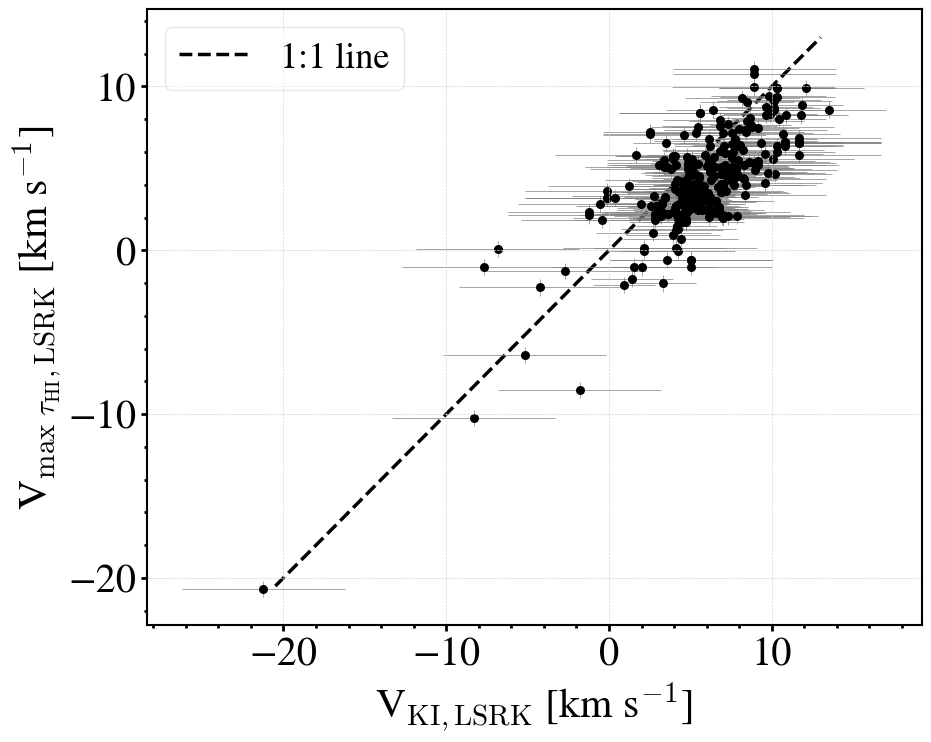

In [ ]:
# Plot
fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)

ax.errorbar(ki_ism_avg_vlsr_obs, emt_min_vlsrs,
             xerr=ki_ism_sig_vlsr_obs*(ki_ism_sig_vlsr_obs>0.), yerr=0.5, zorder=1,
             ls='None', markersize=2,
             markeredgecolor='lightgrey', markeredgewidth=1,
             ecolor='gray', elinewidth=0.5,
             label='')

ax.scatter(ki_ism_avg_vlsr_obs, emt_min_vlsrs, zorder=1, s=30, marker='o',
                 c='k',
                 label=f'')

ax.plot([-20.5, 13.], [-20.5, 13.], c='k', ls='--', lw='2.5', zorder=-1, label='1:1 line')

ax.set_ylabel(r'V$_\mathrm{max ~ \tau_\mathrm{HI}, LSRK}$ [km s$^{-1}$]', fontsize=30)
ax.set_xlabel(r'V$_\mathrm{KI, LSRK}$ [km s$^{-1}$]', fontsize=30, fontweight='normal')

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=29, pad=4)
ax.tick_params(axis='y', labelsize=29)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.legend(loc='upper left', fancybox=True, framealpha=0.5, labelcolor='k', fontsize=26)




ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=1.8,
                    hspace=0.0
                    )

plt.show()

In [ ]:
angular_sep_arr = current_ggdf['sep_distance'] # in degrees
print(np.min(angular_sep_arr), np.max(angular_sep_arr))

stats_series = pd.DataFrame(angular_sep_arr).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

0.00749714302843 0.194353618375598


sep_distance
count    290.000000
mean       0.114071
std        0.044013
min        0.007497
25%        0.082424
50%        0.115202
75%        0.149567
max        0.194354

In [ ]:
x_count = int(series_values[0])
x_mean = round(series_values[1], 1)
x_std = round(series_values[2], 1)
x_minval = round(series_values[3], 1)
x_maxval = round(series_values[-1], 1)
x_median = round(series_values[5], 1)
x_labels = ['Counts', 'Mean', 'Median', 'std', 'Min', 'Max']
x_stats_values = [x_count, x_mean, x_median, x_std, x_minval, x_maxval]

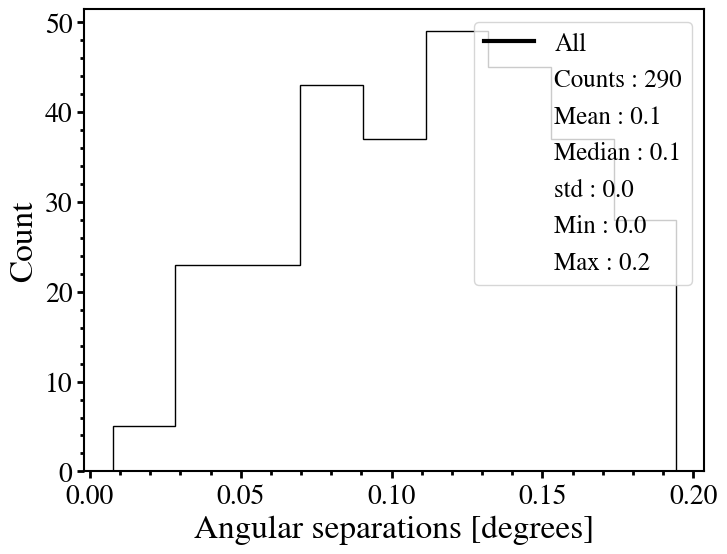

In [ ]:
from scipy import stats

plt.figure(figsize=(8, 6))

plt.hist(angular_sep_arr, bins=np.linspace(np.nanmin(angular_sep_arr), np.nanmax(angular_sep_arr), 10),
         density=False, color='k', histtype='step',
         alpha=1., ls='-', lw=50,
         label='')

ploti, = plt.plot([], [], 'k-', lw=3, label=f'All')
ploti.set_visible(True)

for labeli,vali in zip(x_labels, x_stats_values):
    ploti, = plt.plot([], [], '', label=f"{labeli} : {vali}")
    ploti.set_visible(False)


plt.minorticks_on()
plt.tick_params(axis='x', labelsize=20, pad=4)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=5)
plt.tick_params(which='minor', length=3)

plt.xlabel(r'Angular separations [degrees]', fontsize=24)
plt.ylabel(r'Count', fontsize=24)

plt.legend(loc='upper right', fontsize=18)
plt.show()

In [ ]:
sep_dist_arr = np.tan(np.radians(angular_sep_arr)) * 220. # pc
print(np.min(sep_dist_arr), np.max(sep_dist_arr))

stats_series = pd.DataFrame(sep_dist_arr).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

0.028786962838883018 0.7462671841287122


sep_distance
count    290.000000
mean       0.438002
std        0.168998
min        0.028787
25%        0.316484
50%        0.442344
75%        0.574296
max        0.746267

In [ ]:
x_count = int(series_values[0])
x_mean = round(series_values[1], 1)
x_std = round(series_values[2], 1)
x_minval = round(series_values[3], 1)
x_maxval = round(series_values[-1], 1)
x_median = round(series_values[5], 1)
x_labels = ['Counts', 'Mean', 'Median', 'std', 'Min', 'Max']
x_stats_values = [x_count, x_mean, x_median, x_std, x_minval, x_maxval]

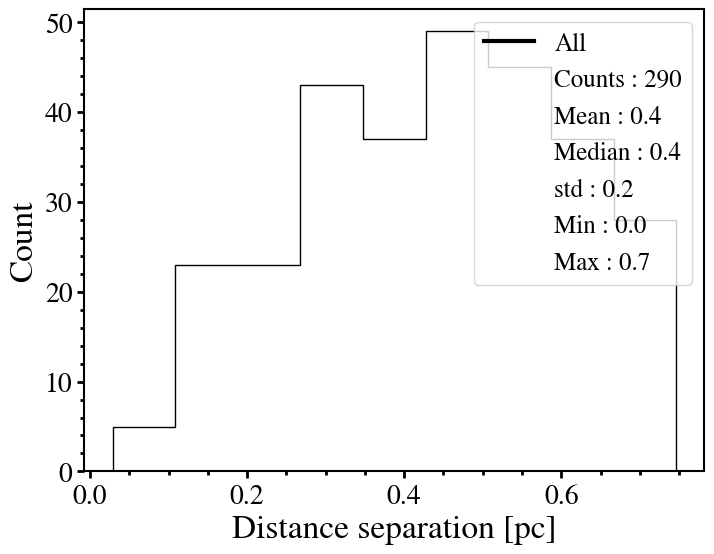

In [ ]:
from scipy import stats

plt.figure(figsize=(8, 6))

plt.hist(sep_dist_arr, bins=np.linspace(np.nanmin(sep_dist_arr), np.nanmax(sep_dist_arr), 10),
         density=False, color='k', histtype='step',
         alpha=1., ls='-', lw=50,
         label='')

ploti, = plt.plot([], [], 'k-', lw=3, label=f'All')
ploti.set_visible(True)

for labeli,vali in zip(x_labels, x_stats_values):
    ploti, = plt.plot([], [], '', label=f"{labeli} : {vali}")
    ploti.set_visible(False)


plt.minorticks_on()
plt.tick_params(axis='x', labelsize=20, pad=4)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=5)
plt.tick_params(which='minor', length=3)

plt.xlabel(r'Distance separation [pc]', fontsize=24)
plt.ylabel(r'Count', fontsize=24)

plt.legend(loc='upper right', fontsize=18)
plt.show()

In [ ]:
gaskap_galah_csv_file = gaskap_hires_result_path / 'gaskap_abs_galah_star_ki_ism_using_gaussfit_smaller_radii_0155.csv'
print(gaskap_galah_csv_file)
ggdf.to_csv(gaskap_galah_csv_file, index=False)